In [152]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress convergence warnings for cleaner output
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

sns.set_palette("deep")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [153]:
data_booking = pd.read_csv('scraped_data/booking_results.csv')
data_expedia = pd.read_csv('scraped_data/expedia_results.csv')

In [154]:
data_booking.isnull().sum()

TTT                        0
LOS                        0
Date of Search             0
Index                      0
Hotel Name                 0
Score                      0
Distance                   0
Price Before Tax           0
Taxes                      0
Total Price                0
Nights & Adults            0
Stars                      0
Subway Access              0
Neighborhood               0
Room Type                  0
Bed Type                 100
Cancellation Policy     4226
Payment Policy         11942
Review Class               0
Number of Reviews          0
dtype: int64

In [155]:
# Preprocessing the data
data_booking = data_booking.copy().drop(columns=['Subway Access', 'Nights & Adults', 'Payment Policy']) # Drop of the columns that are not useful
data_booking = data_booking.copy().dropna(subset=['Bed Type', 'Cancellation Policy']) # Drop of the rows with missing values
data_expedia = data_expedia.copy().dropna(subset=['Classification'])

data_booking = data_booking[data_booking['Review Class'] != 'Review score'] # Drop of the rows with the wrong values

columns_renamed_booking = [i.replace(' ', '_').lower() for i in data_booking.columns] # Renaming the columns to have a more readable name
columns_renamed_expedia = [i.replace(' ', '_').lower() for i in data_expedia.columns]
data_booking.columns = columns_renamed_booking
data_expedia.columns = columns_renamed_expedia

# Renaming columns in both dataframes to have the same names for similar data
data_booking.rename(columns={
    'total_price': 'price_after_tax',
    'score': 'rating',
    'number_of_reviews': 'reviews'
}, inplace=True)

data_expedia.rename(columns={
    'classification': 'review_class'
}, inplace=True)


data_booking['date_of_search'] = pd.to_datetime(data_booking['date_of_search'])
data_expedia['date_of_search'] = pd.to_datetime(data_expedia['date_of_search'])

# Convert 'price_before_tax' in expedia from object to float64 (or int64 if applicable)
data_expedia['price_before_tax'] = data_expedia['price_before_tax'].copy().replace(',', '', regex=True)
data_expedia['price_before_tax'] = pd.to_numeric(data_expedia['price_before_tax'], errors='coerce')

In [156]:
data_expedia.isnull().sum().sum()

0

In [157]:
data_booking.head(2)

,ttt,los,date_of_search,index,hotel_name,rating,distance,price_before_tax,taxes,price_after_tax,stars,neighborhood,room_type,bed_type,cancellation_policy,review_class,reviews
2,1,1,2024-07-20,2,Four Points by Sheraton New York Downtown,7.4,7.0,119,21,140.0,3,Manhattan,"Guest room, 1 Queen",1 queen bed,Free cancellation,Good,2259
4,1,1,2024-07-20,4,Courtyard by Marriott Times Square West,8.2,1.8,151,26,177.0,3,Hell's Kitchen,King Room,1 king bed,Free cancellation,Very Good,2898


In [158]:
data_expedia.head(2)

,ttt,los,date_of_search,index,hotel_name,price_before_tax,price_after_tax,rating,review_class,reviews,neighborhood
0,1,1,2024-07-20,0,Millennium Hilton New York One UN Plaza,256,337,8.2,Very Good,1382,New York
1,1,1,2024-07-20,1,Moxy NYC Chelsea,290,370,8.6,Excellent,1020,Chelsea


## Part B - data exploration

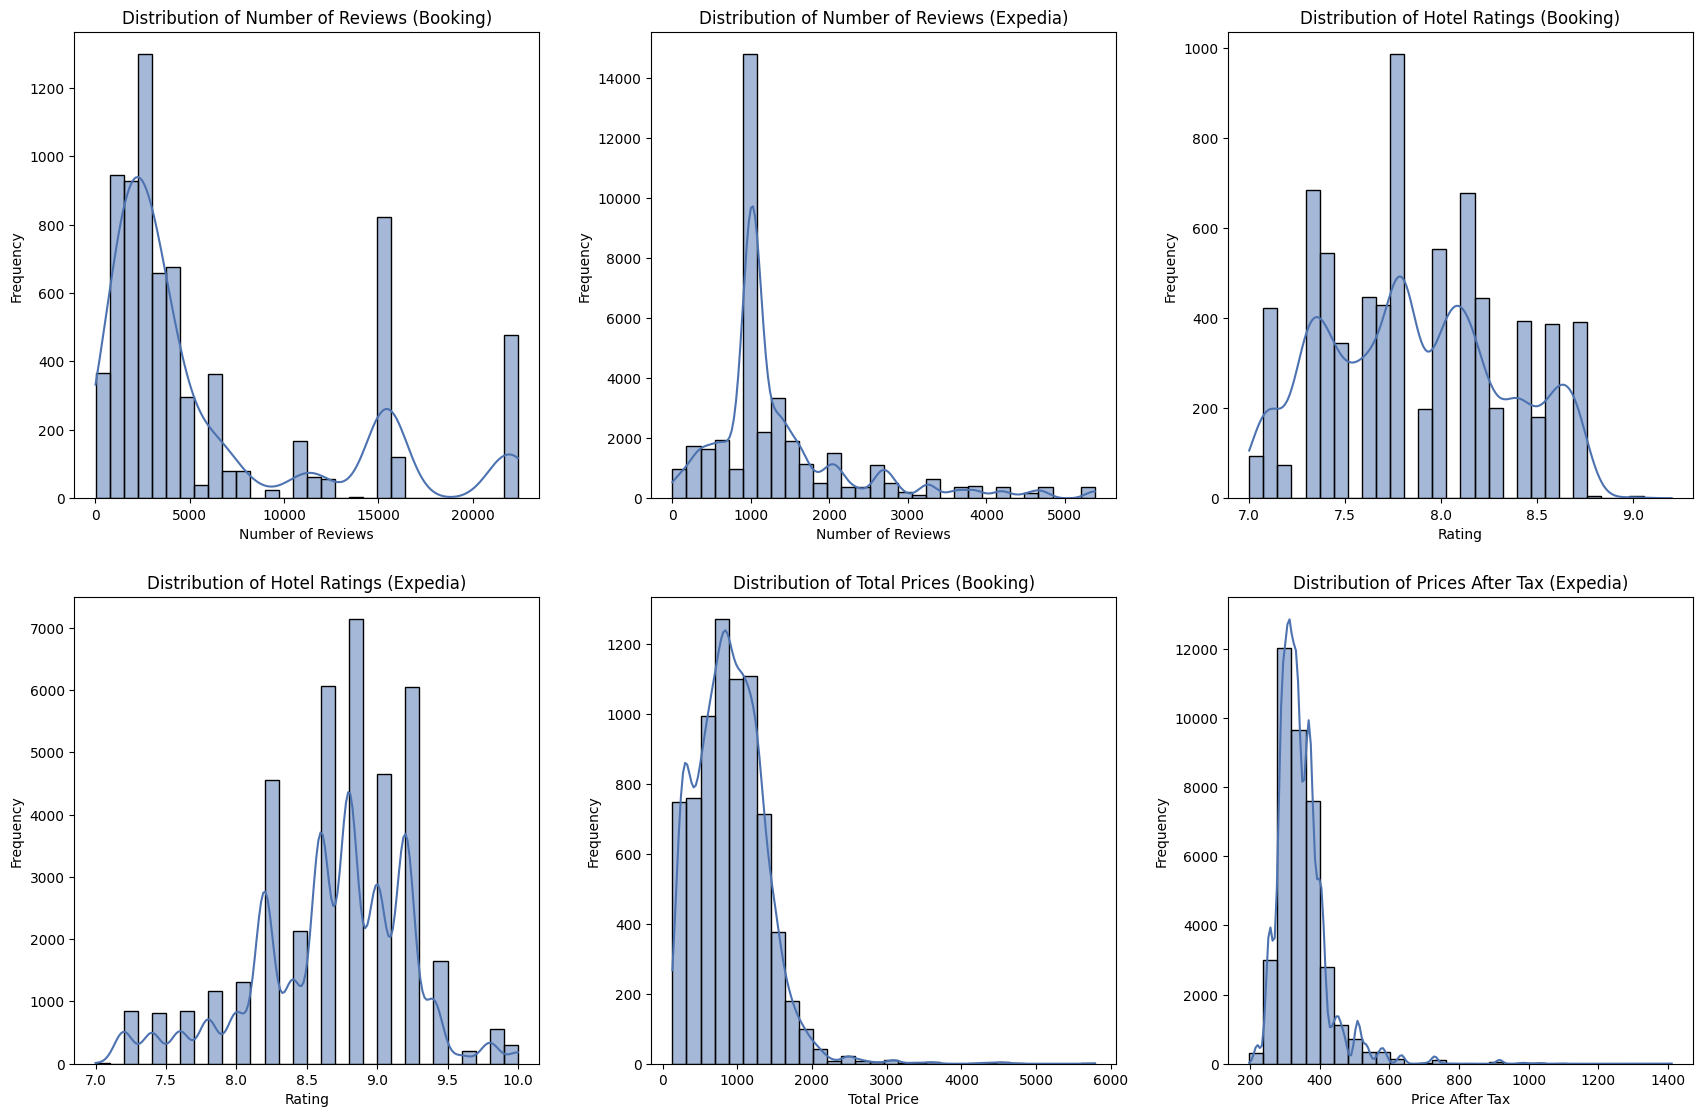

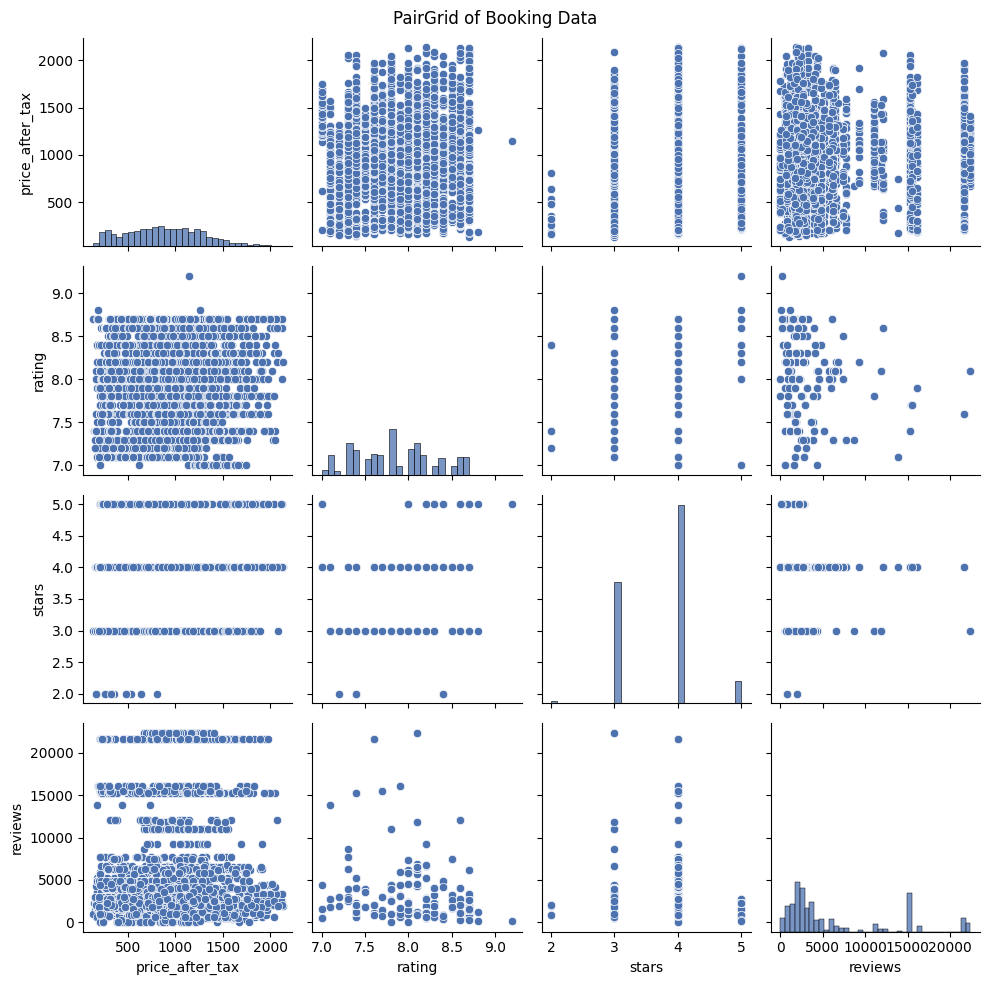

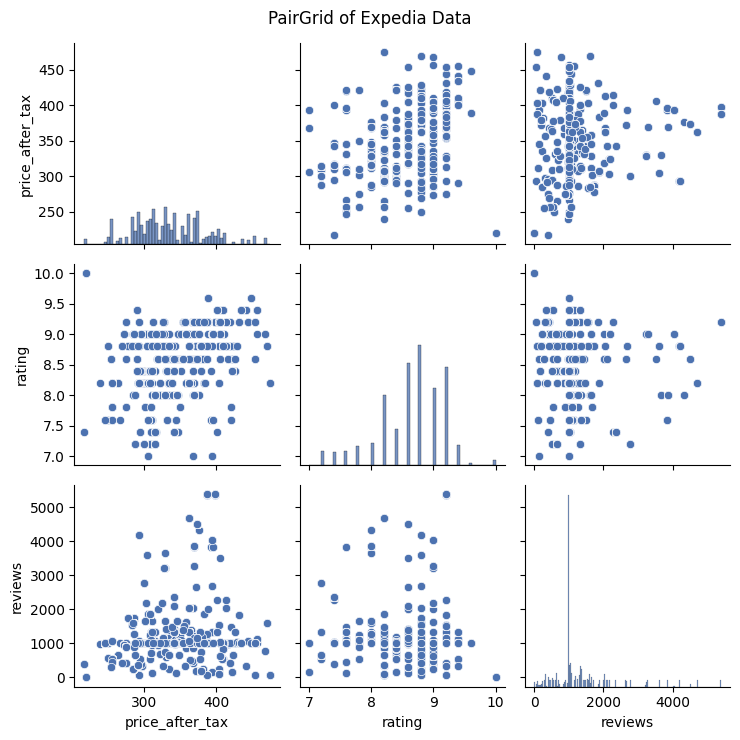

In [159]:
# Set up the figure size and grid layout
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.tight_layout(pad=5.0)

# Distribution of Number of Reviews
sns.histplot(data_booking['reviews'], kde=True, bins=30, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Number of Reviews (Booking)')
axes[0, 0].set_xlabel('Number of Reviews')
axes[0, 0].set_ylabel('Frequency')

sns.histplot(data_expedia['reviews'], kde=True, bins=30, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Number of Reviews (Expedia)')
axes[0, 1].set_xlabel('Number of Reviews')
axes[0, 1].set_ylabel('Frequency')

# Distribution of Hotel Ratings
sns.histplot(data_booking['rating'], kde=True, bins=30, ax=axes[0, 2])
axes[0, 2].set_title('Distribution of Hotel Ratings (Booking)')
axes[0, 2].set_xlabel('Rating')
axes[0, 2].set_ylabel('Frequency')

sns.histplot(data_expedia['rating'], kde=True, bins=30, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Hotel Ratings (Expedia)')
axes[1, 0].set_xlabel('Rating')
axes[1, 0].set_ylabel('Frequency')

# Distribution of Prices
sns.histplot(data_booking['price_after_tax'], kde=True, bins=30, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Total Prices (Booking)')
axes[1, 1].set_xlabel('Total Price')
axes[1, 1].set_ylabel('Frequency')

sns.histplot(data_expedia['price_after_tax'], kde=True, bins=30, ax=axes[1, 2])
axes[1, 2].set_title('Distribution of Prices After Tax (Expedia)')
axes[1, 2].set_xlabel('Price After Tax')
axes[1, 2].set_ylabel('Frequency')

plt.show()

# Outlier Removal using Tukey's 1.5 IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

data_booking = remove_outliers(data_booking, 'price_after_tax')
data_expedia = remove_outliers(data_expedia, 'price_after_tax')

# Ordinal Encoding
ordinal_mapping_booking = {
    'Good': 1,
    'Very Good': 2,
    'Excellent': 3,
    'Wonderful': 4
}

ordinal_mapping_expedia = {
    'Good': 1,
    'Very Good': 2,
    'Excellent': 3,
    'Wonderful': 4,
    'Exceptional': 5
}

data_booking['review_class'] = data_booking['review_class'].map(ordinal_mapping_booking)
data_expedia['review_class'] = data_expedia['review_class'].map(ordinal_mapping_expedia)

def encode_features(data_booking, data_expedia):
    # One-Hot Encoding for Booking
    one_hot_booking = pd.get_dummies(data_booking[['cancellation_policy', 'neighborhood', 'bed_type', 'room_type']], 
                                     prefix=['cancel_policy', 'neighborhood', 'bed_type', 'room_type'])
    data_booking = pd.concat([data_booking, one_hot_booking], axis=1)
    # Drop original columns after encoding
    data_booking.drop(['cancellation_policy', 'neighborhood', 'bed_type', 'room_type'], axis=1, inplace=True)

    # One-Hot Encoding for Expedia
    one_hot_expedia = pd.get_dummies(data_expedia[['neighborhood']], prefix=['neighborhood'])
    data_expedia = pd.concat([data_expedia, one_hot_expedia], axis=1)
    # Drop original column after encoding
    data_expedia.drop(['neighborhood'], axis=1, inplace=True)

    # Label Encoding for hotel_name in both Booking and Expedia
    label_encoder_booking = LabelEncoder()
    data_booking['hotel_name_encoded'] = label_encoder_booking.fit_transform(data_booking['hotel_name'])
    data_booking.drop(['hotel_name'], axis=1, inplace=True)

    label_encoder_expedia = LabelEncoder()
    data_expedia['hotel_name_encoded'] = label_encoder_expedia.fit_transform(data_expedia['hotel_name'])
    data_expedia.drop(['hotel_name'], axis=1, inplace=True)

    return data_booking, data_expedia

data_booking_processed, data_expedia_processed = encode_features(data_booking, data_expedia)

# PairGrid Analysis
sns.pairplot(data_booking[['price_after_tax', 'rating', 'stars', 'reviews']])
plt.suptitle('PairGrid of Booking Data')
plt.tight_layout()
plt.show()

sns.pairplot(data_expedia[['price_after_tax', 'rating', 'reviews']])
plt.suptitle('PairGrid of Expedia Data')
plt.tight_layout()
plt.show()

## Part C -  prediction of rooms prices 

In [160]:
# Selecting only 100 rows from both dataframes to train the models
data_booking_processed = data_booking_processed.sample(n=50, random_state=42)
data_expedia_processed = data_expedia_processed.sample(n=50, random_state=42)

In [161]:
data_booking_processed.head(2)

,ttt,los,date_of_search,index,rating,distance,price_before_tax,taxes,price_after_tax,stars,review_class,reviews,cancel_policy_Free cancellation,neighborhood_Chelsea,neighborhood_East Village,neighborhood_Gramercy,neighborhood_Greenwich Village,neighborhood_Harlem,neighborhood_Hell's Kitchen,neighborhood_Hudson Yards,neighborhood_Kips Bay,neighborhood_Lower East Side,neighborhood_Manhattan,neighborhood_Midtown East,neighborhood_Murray Hill,neighborhood_New York,neighborhood_NoMad,neighborhood_SoHo,neighborhood_Tribeca,neighborhood_Upper East Side,neighborhood_Upper West Side,neighborhood_Washington Heights,bed_type_1 bunk bed,bed_type_1 full bed,bed_type_1 king bed,bed_type_1 queen bed,bed_type_1 twin bed,"bed_type_2 beds (1 king, 1 sofa bed)",bed_type_2 full beds,bed_type_2 twin beds,"bed_type_3 beds (2 fulls, 1 sofa bed)",bed_type_Entire studio•1 bathroom•16m²,bed_type_Entire studio•1 bathroom•17m²,bed_type_Entire studio•1 bathroom•19m²,bed_type_Entire studio•1 bedroom•1 bathroom•19m²,bed_type_Private suite,room_type_1 King Bed,room_type_Accessible Deluxe City View King Room,room_type_Accessible Queen Guest Room,"room_type_Accessible, Guest room, 1 Queen",room_type_Basic Queen Room,room_type_Bunk Bed,room_type_Bunk Bed Cabin with shared bathroom,room_type_Bunk Pod,room_type_Chamber King,room_type_City Room Two Double Beds,room_type_Classic 1 Queen Bed,room_type_Classic Double Room with Two Double Beds,room_type_Classic Double Room with Two Double Beds - Low Floor,room_type_Classic Double Room with Two Double Beds and Tub - Mobility Access,room_type_Classic King Room - High Floor,room_type_Classic King Room - Low Floor,room_type_Classic King Room with Roll-In Shower - Mobility Access,room_type_Classic King Room with Roll-in Shower - Mobility and Hearing Accessible,room_type_Classic Queen Room,room_type_Classic Room,room_type_Classic Room - Disability Access,room_type_Cosmo King,room_type_Cozy Queen Room,room_type_Deluxe 1 Queen Bed,room_type_Deluxe 1 Queen Bed Accessible,room_type_Deluxe City King,room_type_Deluxe City View King Room,room_type_Deluxe Double Room,room_type_Deluxe Double Room - Non Smoking,room_type_Deluxe Double Room with Two Double Beds,room_type_Deluxe Family King,room_type_Deluxe King,room_type_Deluxe King Room,room_type_Deluxe King Studio,room_type_Deluxe Peck Slip King,room_type_Deluxe Queen Room,room_type_Deluxe Room,room_type_Double Room,room_type_Double Room - Bronze,room_type_Double Room - Disability Access,room_type_Double Room - Non-Smoking,"room_type_Double Room with Mobility Access and Roll-In Shower, Non-Smoking",room_type_Double Room with Shared Bathroom,room_type_Double Room with Two Double Beds,room_type_Executive Corner King Room,room_type_Executive King Room,room_type_Executive Queen Room,room_type_Fashionista King,room_type_Fashionista King w/ Communication Features,room_type_Flex Room with Wall Bed,room_type_Full Pod,room_type_Gallery King,room_type_Graduate King,"room_type_Guest Room, 1 King","room_type_Guest Room, 1 King, Cozy King","room_type_Guest room, 1 King, City view","room_type_Guest room, 1 King, Corner room, High floor","room_type_Guest room, 1 King, High floor","room_type_Guest room, 1 Queen",room_type_Handicap Accessible Room,room_type_Interior Queen,room_type_Interior Room - No Windows,room_type_Junior Suite 1 King Bed & Sofa Bed,room_type_King Guest Room - One King Bed - Non-Smoking,room_type_King Room,room_type_King Room - No View,room_type_King Room - Disability Access,room_type_King Room - Disability Access/Hearing Accessible,room_type_King Room - High Floor,room_type_King Room - Mobility Accessible with Bath Tub,room_type_King Room - Non-Smoking,room_type_King Room with City View,room_type_King Room with Landmark City View,room_type_King Room with Roll-In Shower - Disability Access,room_type_King Room with Roll-In Shower - Mobility Access/Non-Smoking,room_type_King Room with Roll-In Shower - Mobility and Hearing Access,room_type_King Room with Roll-In Shower - Mobility/He

first run of the models

Booking Data:
Training Linear Regression...
Training Decision Tree Regressor...
Training Gaussian Process Regressor...
Training Random Forest Regressor...
Training Ridge Regression...
Training KNeighbors Regressor...


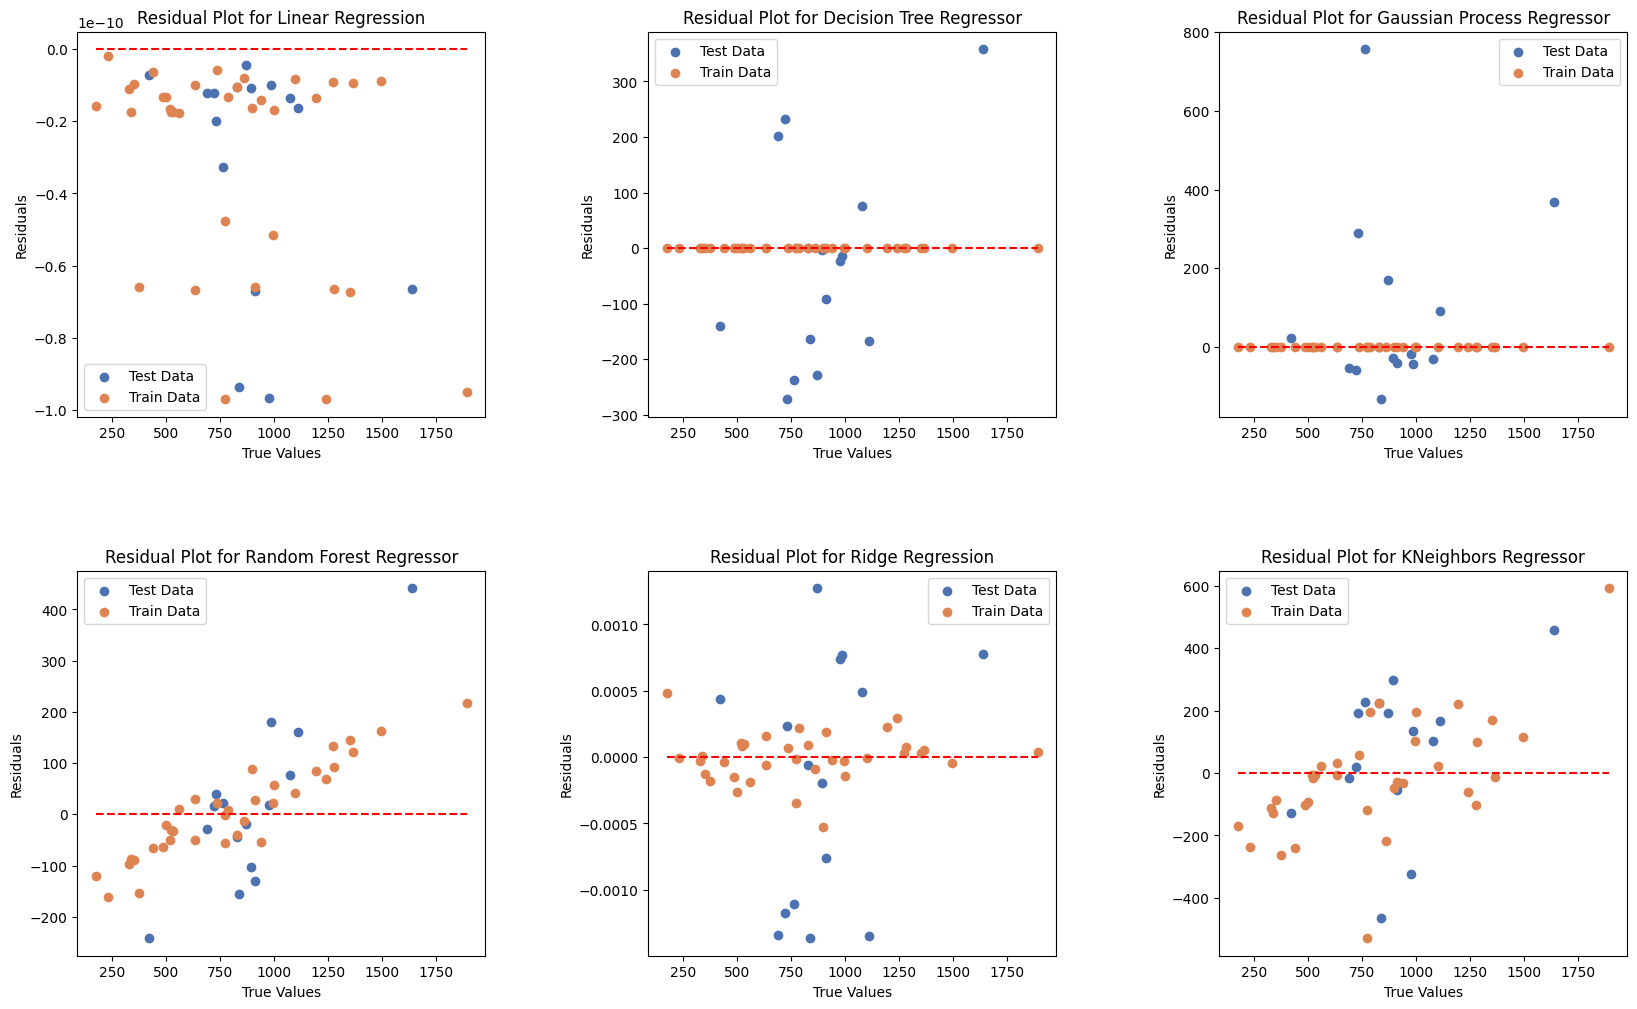

                        Model  \
0           Linear Regression   
1     Decision Tree Regressor   
2  Gaussian Process Regressor   
3     Random Forest Regressor   
4            Ridge Regression   
5        KNeighbors Regressor   

                                         Best Params     MSE Train  \
0                           {'fit_intercept': False}  1.685429e-21   
1  {'min_samples_split': 2, 'max_depth': 10, 'cri...  0.000000e+00   
2  {'alpha': 0.01, 'kernel': 1**2 * Matern(length...  6.287193e-05   
3  {'n_estimators': 100, 'min_samples_split': 2, ...  7.900323e+03   
4              {'alpha': 0.1, 'fit_intercept': True}  3.258142e-08   
5   {'weights': 'uniform', 'p': 1, 'n_neighbors': 3}  3.495507e+04   

       MSE Test    RMSE Train     RMSE Test     MAE Train      MAE Test  \
0  1.980346e-21  4.105398e-11  4.450108e-11  2.921346e-11  3.158978e-11   
1  3.302707e+04  0.000000e+00  1.817335e+02  0.000000e+00  1.473333e+02   
2  5.741666e+04  7.929182e-03  2.396177e+02  6.27009

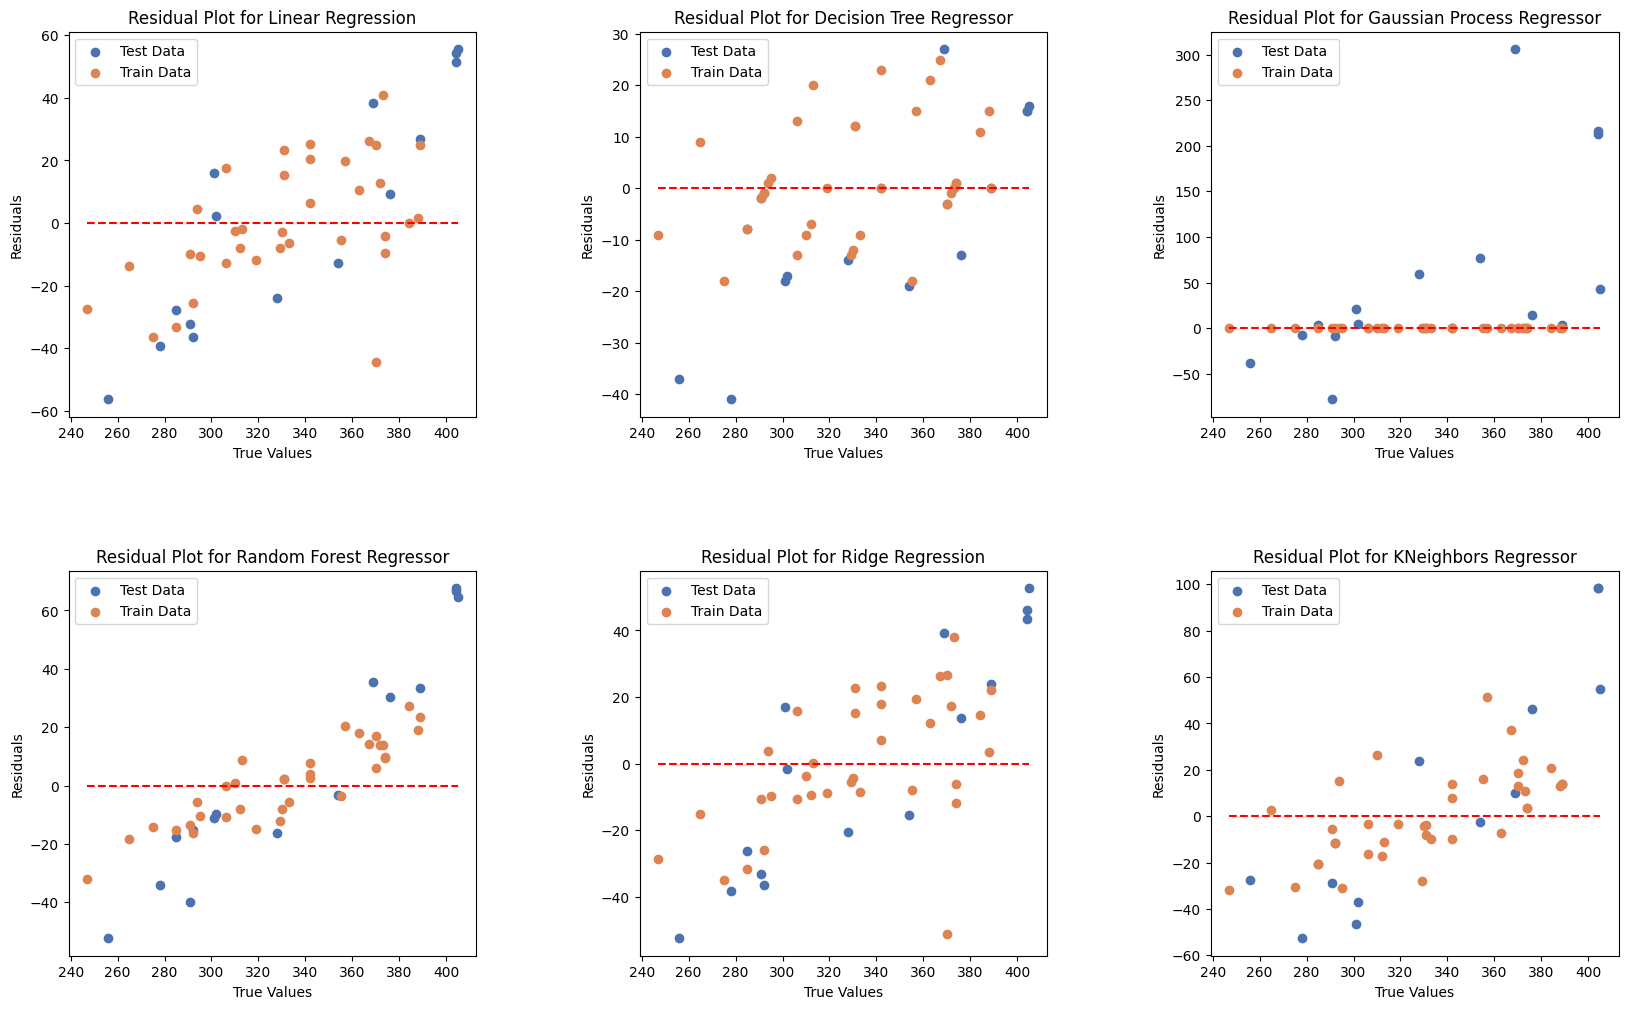

                        Model  \
0           Linear Regression   
1     Decision Tree Regressor   
2  Gaussian Process Regressor   
3     Random Forest Regressor   
4            Ridge Regression   
5        KNeighbors Regressor   

                                         Best Params   MSE Train  \
0                            {'fit_intercept': True}  380.117186   
1  {'min_samples_split': 10, 'max_depth': 5, 'cri...  132.028571   
2  {'alpha': 0.01, 'kernel': 1**2 * Matern(length...    0.000097   
3  {'n_estimators': 50, 'min_samples_split': 5, '...  191.689446   
4               {'alpha': 1, 'fit_intercept': False}  390.790859   
5   {'weights': 'uniform', 'p': 1, 'n_neighbors': 3}  366.517460   

       MSE Test  RMSE Train   RMSE Test  MAE Train   MAE Test  R2 Train  \
0   1318.519399   19.496594   36.311422  15.664396  32.152152  0.725536   
1    392.866667   11.490369   19.820864   8.771429  16.200000  0.904669   
2  13682.703080    0.009871  116.973087   0.004792  72.839655  1.0

In [162]:
# Function to train and evaluate models
def train_and_evaluate_models(data, target_column):
    X = data.drop(columns=[target_column])
    y = data[target_column]
    
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Models to be trained
    models = {
        "Linear Regression": LinearRegression(),
        "Decision Tree Regressor": DecisionTreeRegressor(),
        "Gaussian Process Regressor": GaussianProcessRegressor(kernel=C(1.0, (1e-4, 1e3)) * RBF(1.0, (1e-4, 1e2))),
        "Random Forest Regressor": RandomForestRegressor(),
        "Ridge Regression": Ridge(),
        "KNeighbors Regressor": KNeighborsRegressor()
    }
    
    # Hyperparameter grids
    param_grids = {
        "Linear Regression": {
            'fit_intercept': [True, False]
        },
        "Decision Tree Regressor": {
            'max_depth': [5, 10, 20, None],
            'min_samples_split': [2, 5, 10],
            'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
        },
        "Gaussian Process Regressor": {
            'alpha': [1e-2, 1e-3, 1e-4],
            'kernel': [C(1.0, (1e-4, 1e3)) * RBF(1.0, (1e-4, 1e2)), C(1.0, (1e-4, 1e3)) * Matern(nu=1.5)]
        },
        "Random Forest Regressor": {
            'n_estimators': [50, 100, 200],
            'max_features': ['sqrt', 'log2'],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10]
        },
        "Ridge Regression": {
            'alpha': [0.1, 1, 10],
            'fit_intercept': [True, False],
        },
        "KNeighbors Regressor": {
            'n_neighbors': [3, 5, 7, 10],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        }
    }
    
    # Setup for 2x3 grid of subplots
    fig, axs = plt.subplots(2, 3, figsize=(20, 12))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust space between plots
    
    # Counter for subplot index
    plot_row, plot_col = 0, 0
    
    # Training and evaluating models
    results = []
    for model_name, model in models.items():
        print(f"Training {model_name}...")
        
        # Use GridSearchCV if the number of parameter combinations is small, otherwise RandomizedSearchCV
        if model_name in param_grids:
            param_grid = param_grids[model_name]
            if len(param_grid) * len(list(param_grid.values())[0]) <= 10:
                model = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
            else:
                model = RandomizedSearchCV(model, param_grid, cv=5, n_iter=10, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
        
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Calculate error metrics
        mse_train = mean_squared_error(y_train, y_pred_train)
        mse_test = mean_squared_error(y_test, y_pred_test)
        rmse_train = np.sqrt(mse_train)
        rmse_test = np.sqrt(mse_test)
        mae_train = mean_absolute_error(y_train, y_pred_train)
        mae_test = mean_absolute_error(y_test, y_pred_test)
        r2_train = r2_score(y_train, y_pred_train)
        r2_test = r2_score(y_test, y_pred_test)
        
        results.append({
            "Model": model_name,
            "Best Params": model.best_params_ if hasattr(model, 'best_params_') else None,
            "MSE Train": mse_train,
            "MSE Test": mse_test,
            "RMSE Train": rmse_train,
            "RMSE Test": rmse_test,
            "MAE Train": mae_train,
            "MAE Test": mae_test,
            "R2 Train": r2_train,
            "R2 Test": r2_test
        })
        
        # Plot residuals in the grid
        ax = axs[plot_row, plot_col]
        ax.scatter(y_test, y_test - y_pred_test, label="Test Data")
        ax.scatter(y_train, y_train - y_pred_train, label="Train Data")
        ax.hlines(y=0, xmin=min(y), xmax=max(y), colors='r', linestyles='dashed')
        ax.set_xlabel("True Values")
        ax.set_ylabel("Residuals")
        ax.set_title(f"Residual Plot for {model_name}")
        ax.legend()
        
        # Update subplot index
        plot_col += 1
        if plot_col > 2:
            plot_col = 0
            plot_row += 1
    
    plt.show()
    
    # Display results
    results_df = pd.DataFrame(results)
    return results_df

# Apply the function to both datasets
print("Booking Data:")
results_booking = train_and_evaluate_models(data_booking_processed.drop(columns='date_of_search'), 'price_after_tax')
print(results_booking)

print("\nExpedia Data:")
results_expedia = train_and_evaluate_models(data_expedia_processed.drop(columns='date_of_search'), 'price_after_tax')
print(results_expedia)

running the function with the feature engineering thing

Booking Data:
Training Linear Regression...
Training Decision Tree Regressor...
Training Gaussian Process Regressor...
Training Random Forest Regressor...
Training Ridge Regression...
Training KNeighbors Regressor...


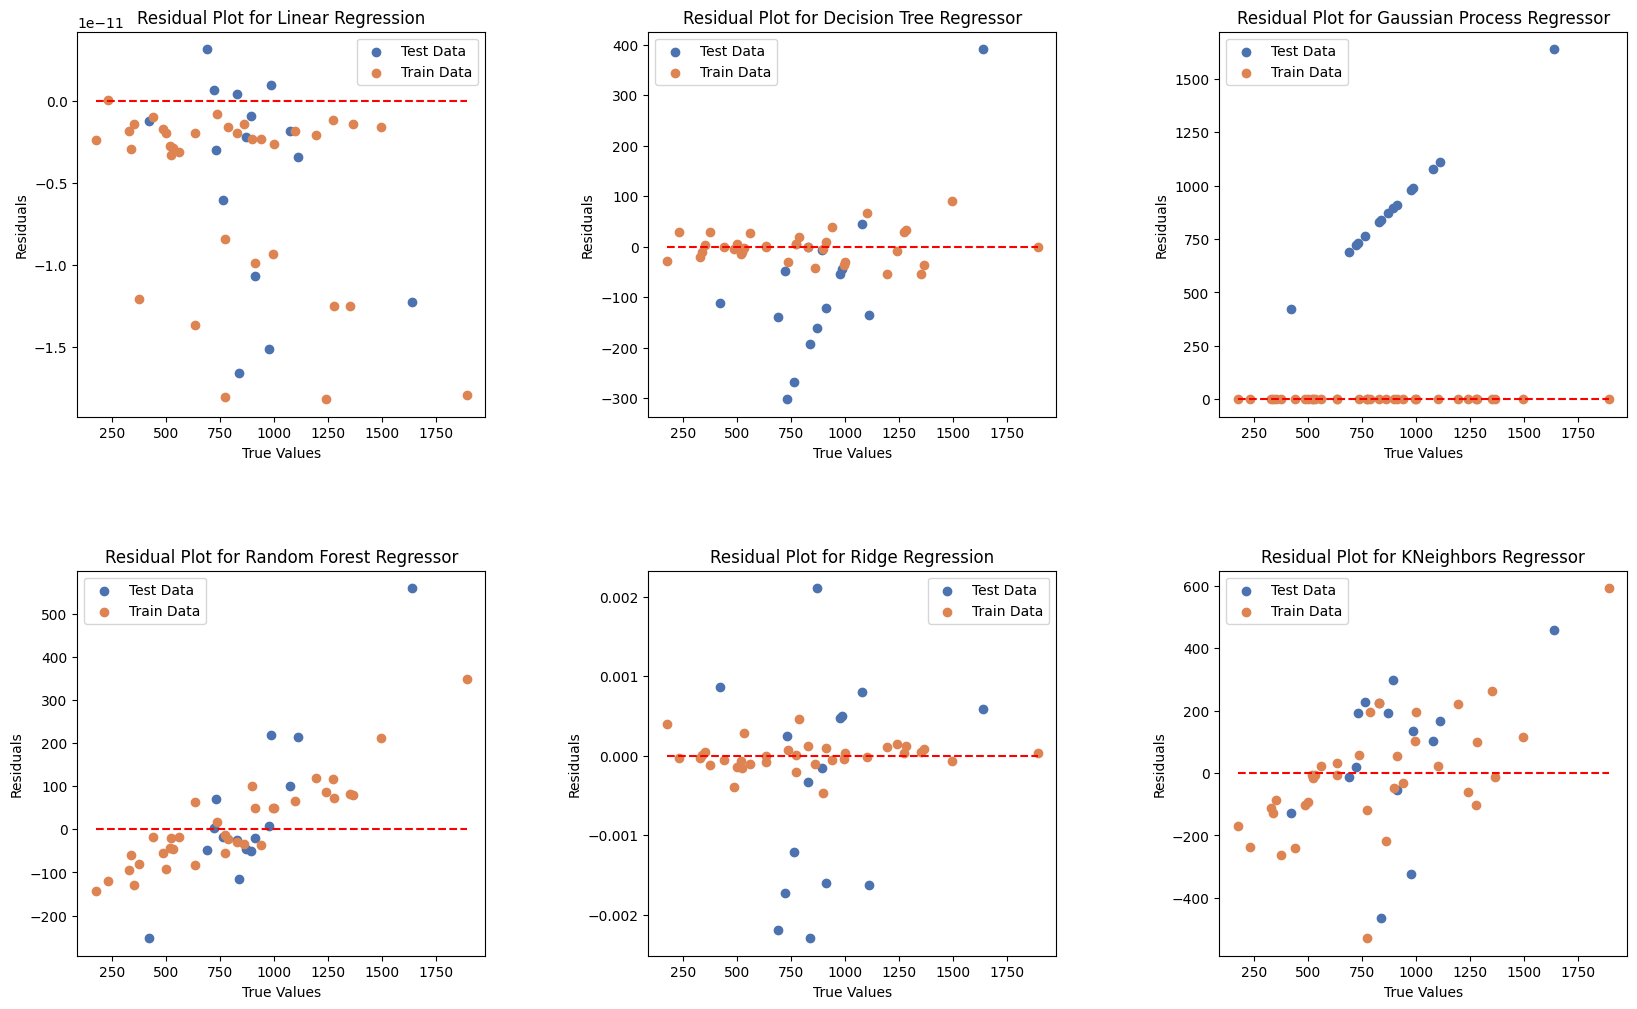

                        Model  \
0           Linear Regression   
1     Decision Tree Regressor   
2  Gaussian Process Regressor   
3     Random Forest Regressor   
4            Ridge Regression   
5        KNeighbors Regressor   

                                         Best Params     MSE Train  \
0                           {'fit_intercept': False}  5.672255e-23   
1  {'min_samples_split': 5, 'max_depth': 20, 'cri...  9.458667e+02   
2  {'alpha': 0.01, 'kernel': 1**2 * RBF(length_sc...  8.126268e-05   
3  {'n_estimators': 100, 'min_samples_split': 2, ...  9.893758e+03   
4             {'alpha': 0.1, 'fit_intercept': False}  3.058434e-08   
5   {'weights': 'uniform', 'p': 1, 'n_neighbors': 3}  3.616576e+04   

       MSE Test    RMSE Train     RMSE Test     MAE Train      MAE Test  \
0  5.652250e-23  7.531437e-12  7.518145e-12  5.152450e-12  5.233384e-12   
1  3.026111e+04  3.075495e+01  1.739572e+02  2.241429e+01  1.348167e+02   
2  8.722465e+05  9.014582e-03  9.339414e+02  8.09049

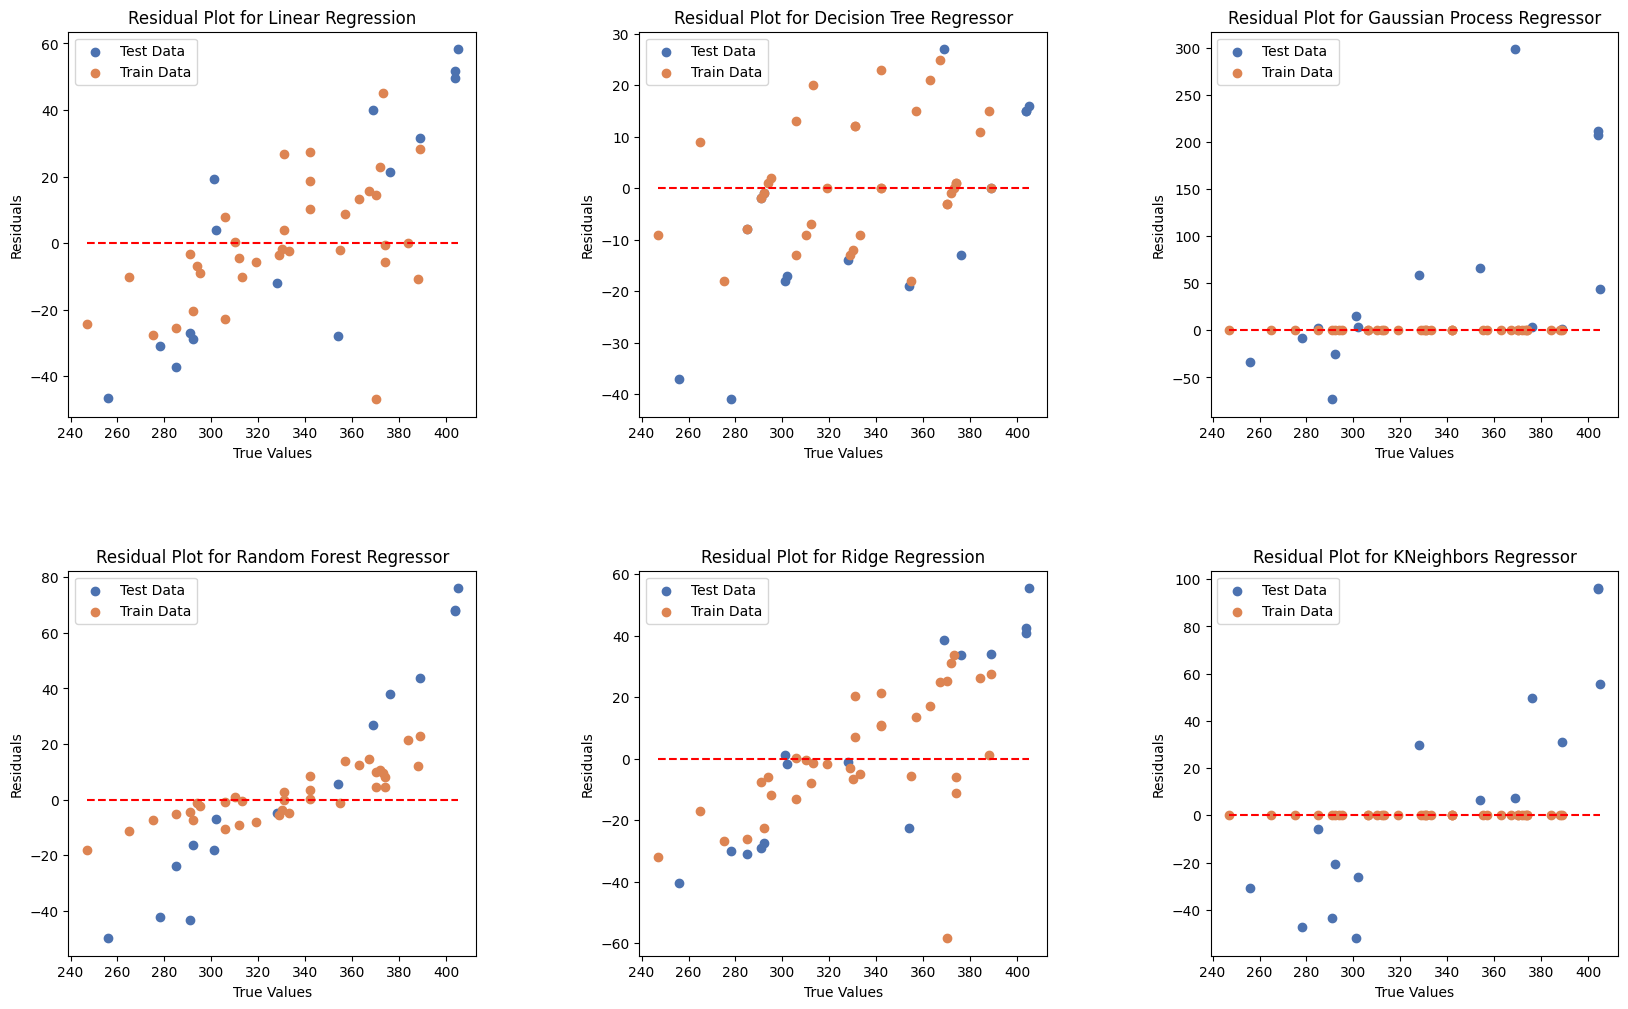

                        Model  \
0           Linear Regression   
1     Decision Tree Regressor   
2  Gaussian Process Regressor   
3     Random Forest Regressor   
4            Ridge Regression   
5        KNeighbors Regressor   

                                         Best Params   MSE Train  \
0                            {'fit_intercept': True}  335.233623   
1  {'min_samples_split': 10, 'max_depth': 5, 'cri...  132.028571   
2  {'alpha': 0.01, 'kernel': 1**2 * Matern(length...    0.000089   
3  {'n_estimators': 100, 'min_samples_split': 2, ...   89.730371   
4              {'alpha': 10, 'fit_intercept': False}  393.788775   
5  {'weights': 'distance', 'p': 1, 'n_neighbors': 5}    0.000000   

       MSE Test  RMSE Train   RMSE Test  MAE Train   MAE Test  R2 Train  \
0   1263.825162   18.309386   35.550319  13.910466  32.397480  0.757944   
1    392.866667   11.490369   19.820864   8.771429  16.200000  0.904669   
2  12894.210396    0.009432  113.552677   0.004645  70.103493  1.0

In [163]:
def add_features(data):
    # Extract day of week from date_of_search
    data['day_of_week'] = data['date_of_search'].dt.dayofweek
    
    # Calculate days until end of month
    data['end_of_month'] = data['date_of_search'].dt.daysinmonth - data['date_of_search'].dt.day
    
    # Additional feature engineering
    # Week of the year
    data['week_of_year'] = data['date_of_search'].dt.isocalendar().week
    
    # Is weekend?
    data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    
    # Month start indicator
    data['start_of_month'] = data['date_of_search'].dt.day.apply(lambda x: 1 if x <= 7 else 0)
    
    # Quarter of the year
    data['quarter'] = data['date_of_search'].dt.quarter

    data['search_day'] = data['date_of_search'].dt.day

    data['search_month'] = data['date_of_search'].dt.month
    
    data['search_year'] = data['date_of_search'].dt.year
    data.drop(['date_of_search'], axis=1, inplace=True)
    
    return data

data_booking_processed = add_features(data_booking_processed)
data_expedia_processed = add_features(data_expedia_processed)

# Apply the function to both datasets
print("Booking Data:")
results_booking = train_and_evaluate_models(data_booking_processed, 'price_after_tax')
print(results_booking)

print("\nExpedia Data:")
results_expedia = train_and_evaluate_models(data_expedia_processed, 'price_after_tax')
print(results_expedia)

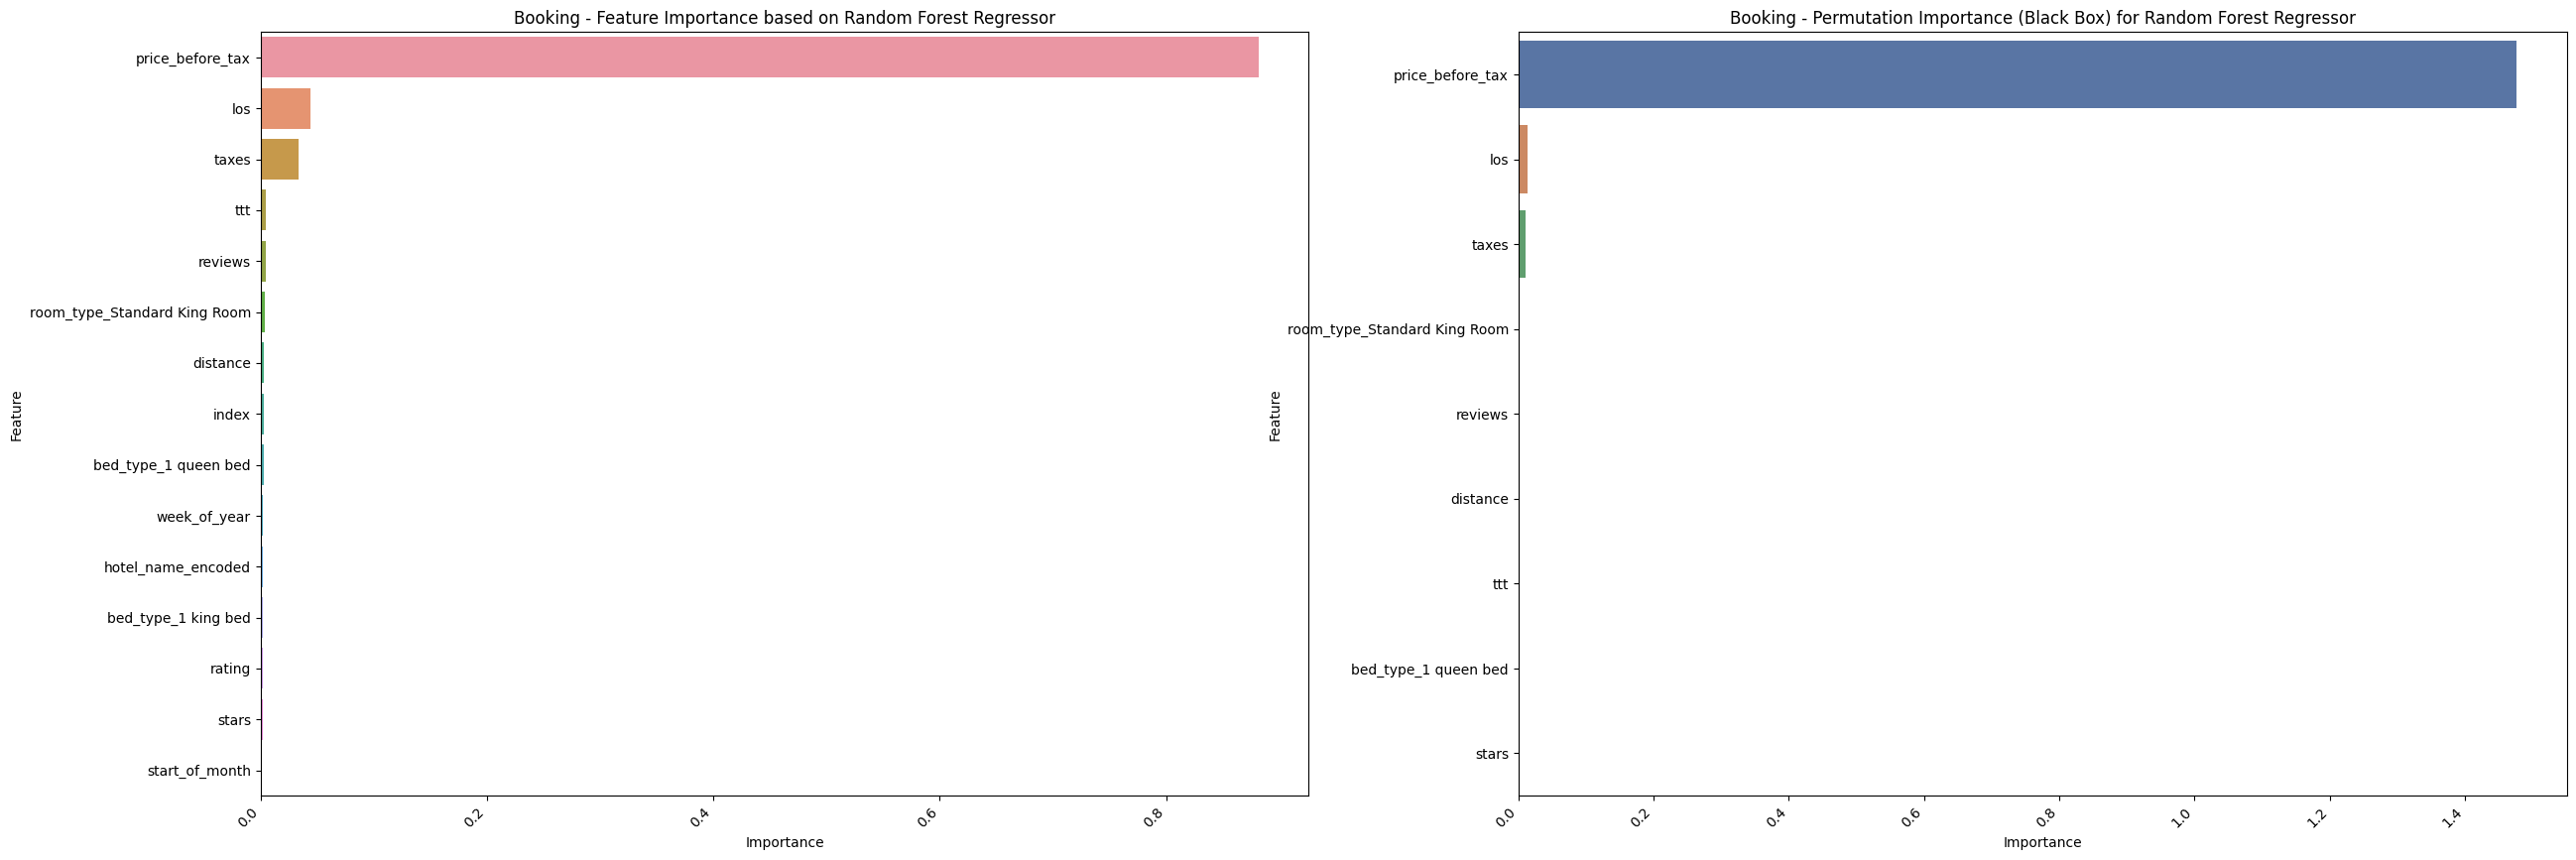

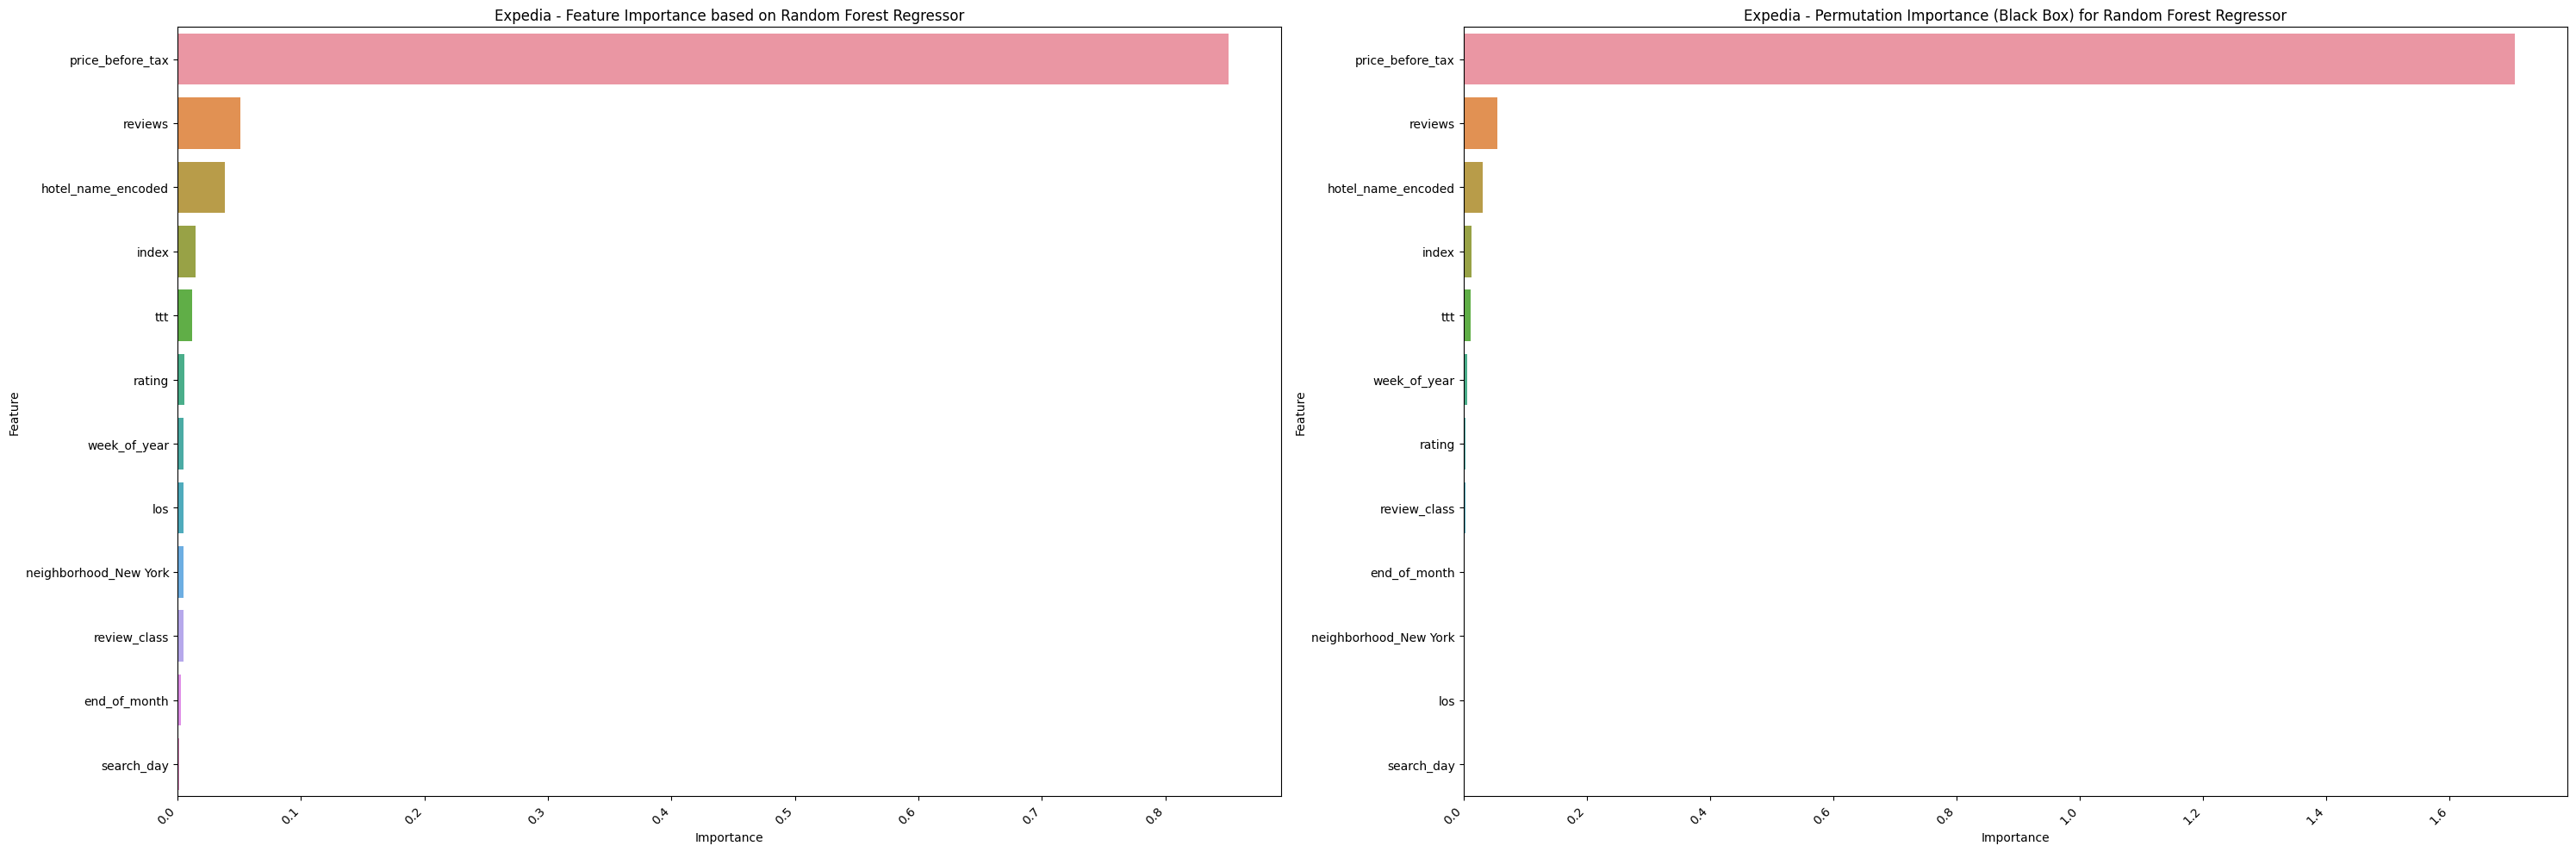

In [164]:
def feature_importance_analysis(model, X_train, y_train, model_name, dataset_name, axes, importance_threshold=0.001):
    # Method 1: Based on the specific algorithm
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
    # Filter features based on importance threshold
    feature_importance_df = feature_importance_df[feature_importance_df['Importance'] > importance_threshold]
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, ax=axes[0])
    axes[0].set_title(f'{dataset_name} - Feature Importance based on {model_name}')
    
    # Method 2: Treat the model as a black box
    perm_importance = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42)
    perm_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': perm_importance.importances_mean})
    # Filter features based on importance threshold
    perm_importance_df = perm_importance_df[perm_importance_df['Importance'] > importance_threshold]
    perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=False)
    sns.barplot(x='Importance', y='Feature', data=perm_importance_df, ax=axes[1])
    axes[1].set_title(f'{dataset_name} - Permutation Importance (Black Box) for {model_name}')

# Adjust figure size and layout
fig, axs_booking = plt.subplots(1, 2, figsize=(30, 10)) # Increased figure size
fig, axs_expedia = plt.subplots(1, 2, figsize=(30, 10)) # Increased figure size

# Apply feature importance analysis for Random Forest Regressor on both datasets
rf_model_booking = RandomForestRegressor().fit(data_booking_processed.drop(columns=['price_after_tax']), data_booking_processed['price_after_tax'])
feature_importance_analysis(rf_model_booking, data_booking_processed.drop(columns=['price_after_tax']), data_booking_processed['price_after_tax'], "Random Forest Regressor", "Booking", axs_booking)

rf_model_expedia = RandomForestRegressor().fit(data_expedia_processed.drop(columns=['price_after_tax']), data_expedia_processed['price_after_tax'])
feature_importance_analysis(rf_model_expedia, data_expedia_processed.drop(columns=['price_after_tax']), data_expedia_processed['price_after_tax'], "Random Forest Regressor", "Expedia", axs_expedia)

# Improve layout and label rotation for better visibility
for ax in axs_booking:
    plt.sca(ax)
    plt.xticks(rotation=45, ha="right")
for ax in axs_expedia:
    plt.sca(ax)
    plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

Booking Data (Normalized):
Training Linear Regression...
Training Decision Tree Regressor...


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\AppData\Lo

Training Gaussian Process Regressor...
Training Random Forest Regressor...
Training Ridge Regression...
Training KNeighbors Regressor...


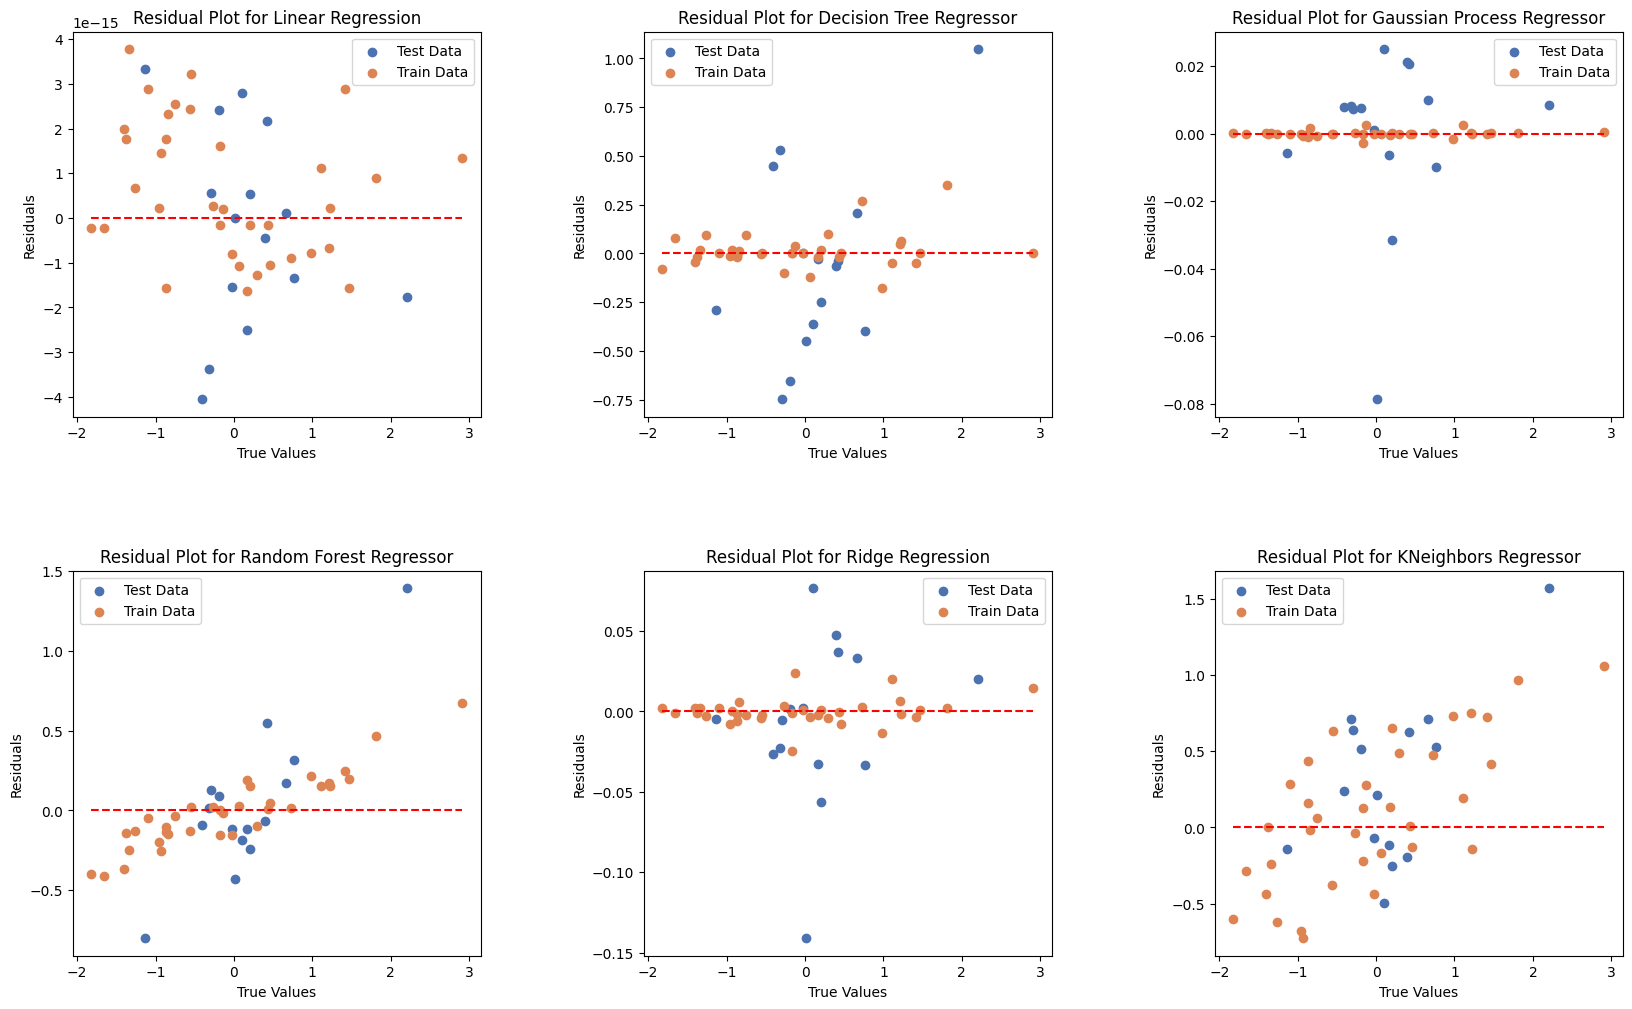

                        Model  \
0           Linear Regression   
1     Decision Tree Regressor   
2  Gaussian Process Regressor   
3     Random Forest Regressor   
4            Ridge Regression   
5        KNeighbors Regressor   

                                         Best Params     MSE Train  \
0                           {'fit_intercept': False}  2.649004e-30   
1  {'min_samples_split': 5, 'max_depth': 5, 'crit...  8.793977e-03   
2  {'alpha': 0.0001, 'kernel': 1**2 * RBF(length_...  7.906897e-07   
3  {'n_estimators': 100, 'min_samples_split': 2, ...  4.996221e-02   
4             {'alpha': 0.1, 'fit_intercept': False}  6.621638e-05   
5   {'weights': 'uniform', 'p': 2, 'n_neighbors': 3}  2.316802e-01   

       MSE Test    RMSE Train     RMSE Test     MAE Train      MAE Test  \
0  4.780481e-30  1.627576e-15  2.186431e-15  1.309964e-15  1.796711e-15   
1  2.168313e-01  9.377621e-02  4.656515e-01  5.514353e-02  3.674926e-01   
2  6.170116e-04  8.892074e-04  2.483972e-02  4.82930

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\AppData\Lo

Training Gaussian Process Regressor...
Training Random Forest Regressor...
Training Ridge Regression...
Training KNeighbors Regressor...


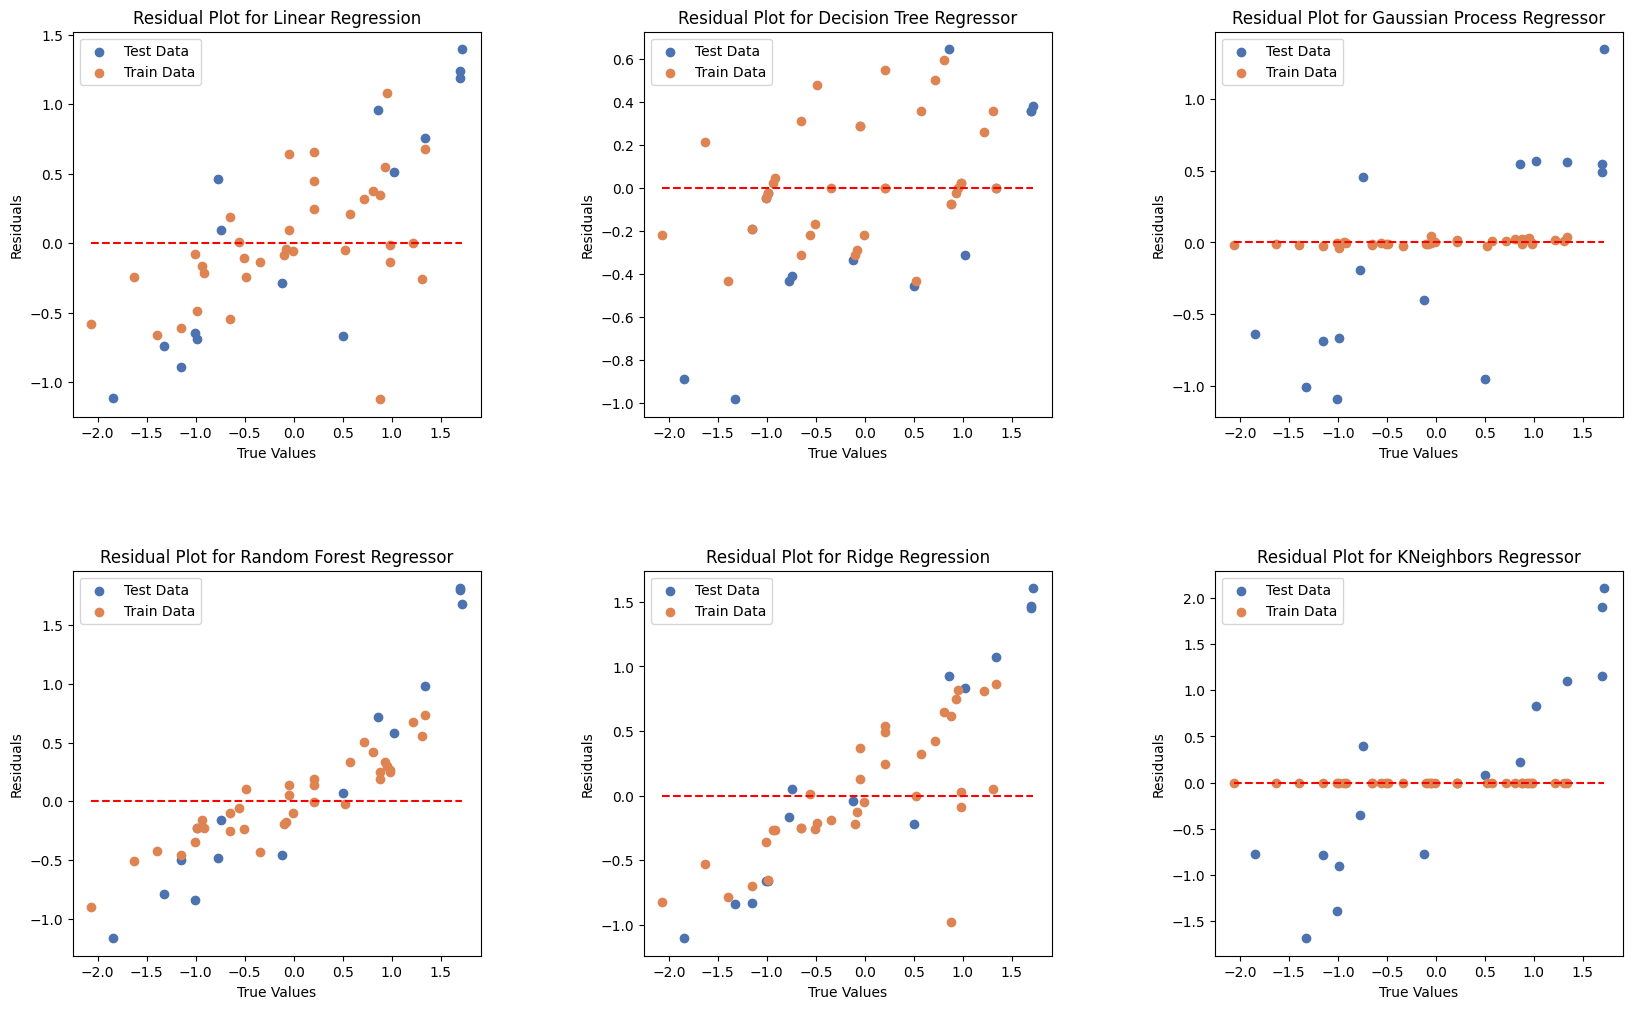

                        Model  \
0           Linear Regression   
1     Decision Tree Regressor   
2  Gaussian Process Regressor   
3     Random Forest Regressor   
4            Ridge Regression   
5        KNeighbors Regressor   

                                         Best Params  MSE Train  MSE Test  \
0                           {'fit_intercept': False}   0.192230  0.724704   
1  {'min_samples_split': 10, 'max_depth': 5, 'cri...   0.075708  0.225278   
2  {'alpha': 0.01, 'kernel': 1**2 * Matern(length...   0.000352  0.543025   
3  {'n_estimators': 50, 'min_samples_split': 5, '...   0.127782  0.979957   
4              {'alpha': 10, 'fit_intercept': False}   0.243780  0.874456   
5  {'weights': 'distance', 'p': 1, 'n_neighbors': 3}   0.000000  1.267921   

   RMSE Train  RMSE Test  MAE Train  MAE Test  R2 Train   R2 Test  
0    0.438440   0.851295   0.333103  0.775797  0.757944  0.508871  
1    0.275151   0.474635   0.210042  0.387929  0.904669  0.847330  
2    0.018769   0.736902

In [165]:
# Normalization Techniques
def normalize_data(data):
    scaler = StandardScaler()
    numeric_features = data.select_dtypes(include=[np.number]).columns.tolist()
    data[numeric_features] = scaler.fit_transform(data[numeric_features])
    return data

# Apply normalization and evaluate models
data_booking_normalized = normalize_data(data_booking_processed.copy())
data_expedia_normalized = normalize_data(data_expedia_processed.copy())

print("Booking Data (Normalized):")
results_booking_normalized = train_and_evaluate_models(data_booking_normalized, 'price_after_tax')
print(results_booking_normalized)

print("\nExpedia Data (Normalized):")
results_expedia_normalized = train_and_evaluate_models(data_expedia_normalized, 'price_after_tax')
print(results_expedia_normalized)

Booking Data (Future Split):


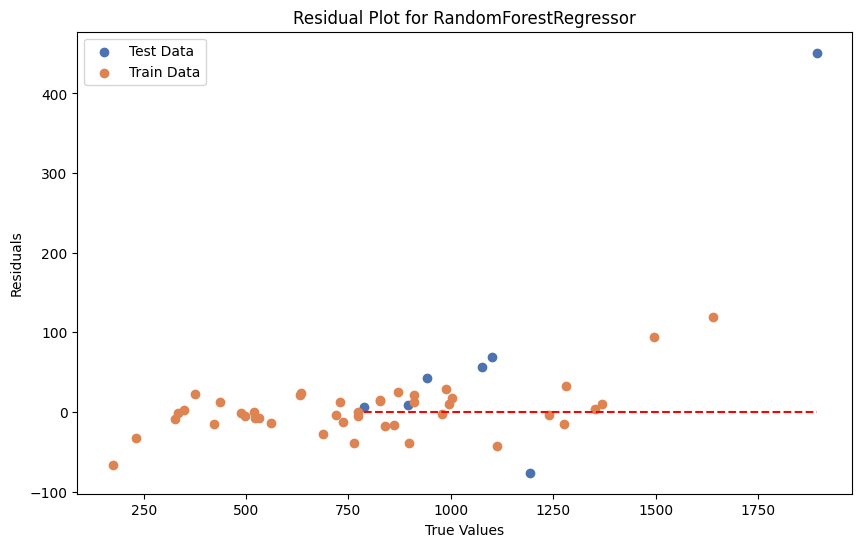

{'Model': 'RandomForestRegressor', 'MSE Train': 968.5928720930235, 'MSE Test': 31322.10594285713, 'RMSE Train': 31.12222472917101, 'RMSE Test': 176.98052419081918, 'MAE Train': 20.529069767441857, 'MAE Test': 101.64285714285715, 'R2 Train': 0.9918722014677459, 'R2 Test': 0.7259407735597448}

Expedia Data (Future Split):


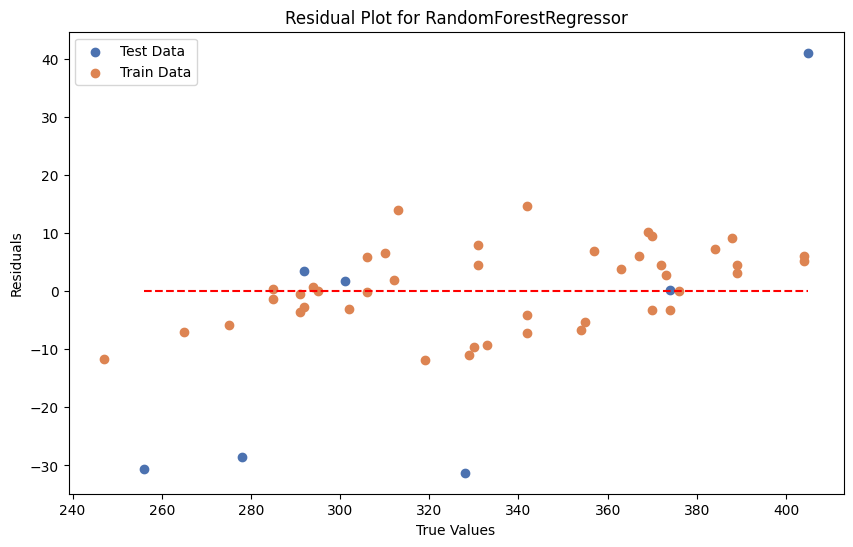

{'Model': 'RandomForestRegressor', 'MSE Train': 46.230753488372116, 'MSE Test': 632.0892285714286, 'RMSE Train': 6.79932007544667, 'RMSE Test': 25.141384778317775, 'MAE Train': 5.6646511627907, 'MAE Test': 19.542857142857144, 'R2 Train': 0.9709294731637044, 'R2 Test': 0.7428270073235133}


In [166]:
# Additional Experiment with Different Train/Test Split
def split_train_test_future(data, target_column, ttt_threshold):
    train_data = data[data['ttt'] <= ttt_threshold]
    test_data = data[data['ttt'] > ttt_threshold]
    
    X_train = train_data.drop(columns=[target_column])
    y_train = train_data[target_column]
    X_test = test_data.drop(columns=[target_column])
    y_test = test_data[target_column]
    
    return X_train, X_test, y_train, y_test

def train_and_evaluate_best_model(data, target_column, best_model):
    X_train, X_test, y_train, y_test = split_train_test_future(data, target_column, 25)
    
    best_model.fit(X_train, y_train)
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    
    # Calculate error metrics
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    results = {
        "Model": best_model.__class__.__name__,
        "MSE Train": mse_train,
        "MSE Test": mse_test,
        "RMSE Train": rmse_train,
        "RMSE Test": rmse_test,
        "MAE Train": mae_train,
        "MAE Test": mae_test,
        "R2 Train": r2_train,
        "R2 Test": r2_test
    }
    
    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_test - y_pred_test, label="Test Data")
    plt.scatter(y_train, y_train - y_pred_train, label="Train Data")
    plt.hlines(y=0, xmin=min(y_test), xmax=max(y_test), colors='r', linestyles='dashed')
    plt.xlabel("True Values")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot for {best_model.__class__.__name__}")
    plt.legend()
    plt.show()
    
    return results

# Train and evaluate the best model with different split
best_model = RandomForestRegressor()  # Assuming Random Forest Regressor is the best model
print("Booking Data (Future Split):")
results_booking_future_split = train_and_evaluate_best_model(data_booking_processed, 'price_after_tax', best_model)
print(results_booking_future_split)

print("\nExpedia Data (Future Split):")
results_expedia_future_split = train_and_evaluate_best_model(data_expedia_processed, 'price_after_tax', best_model)
print(results_expedia_future_split)

## Part D - Learning the difference in prices between the competitors websites

Training Linear Regression...
Training Decision Tree Regressor...
Training Gaussian Process Regressor...
Training Random Forest Regressor...
Training Ridge Regression...
Training KNeighbors Regressor...


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [-71322.95185185 -47939.88455735 -59365.78826739             nan
             nan -53800.20247564 -58478.42312925 -51448.97968566
 -76112.66296296             nan]
  warnings.warn(


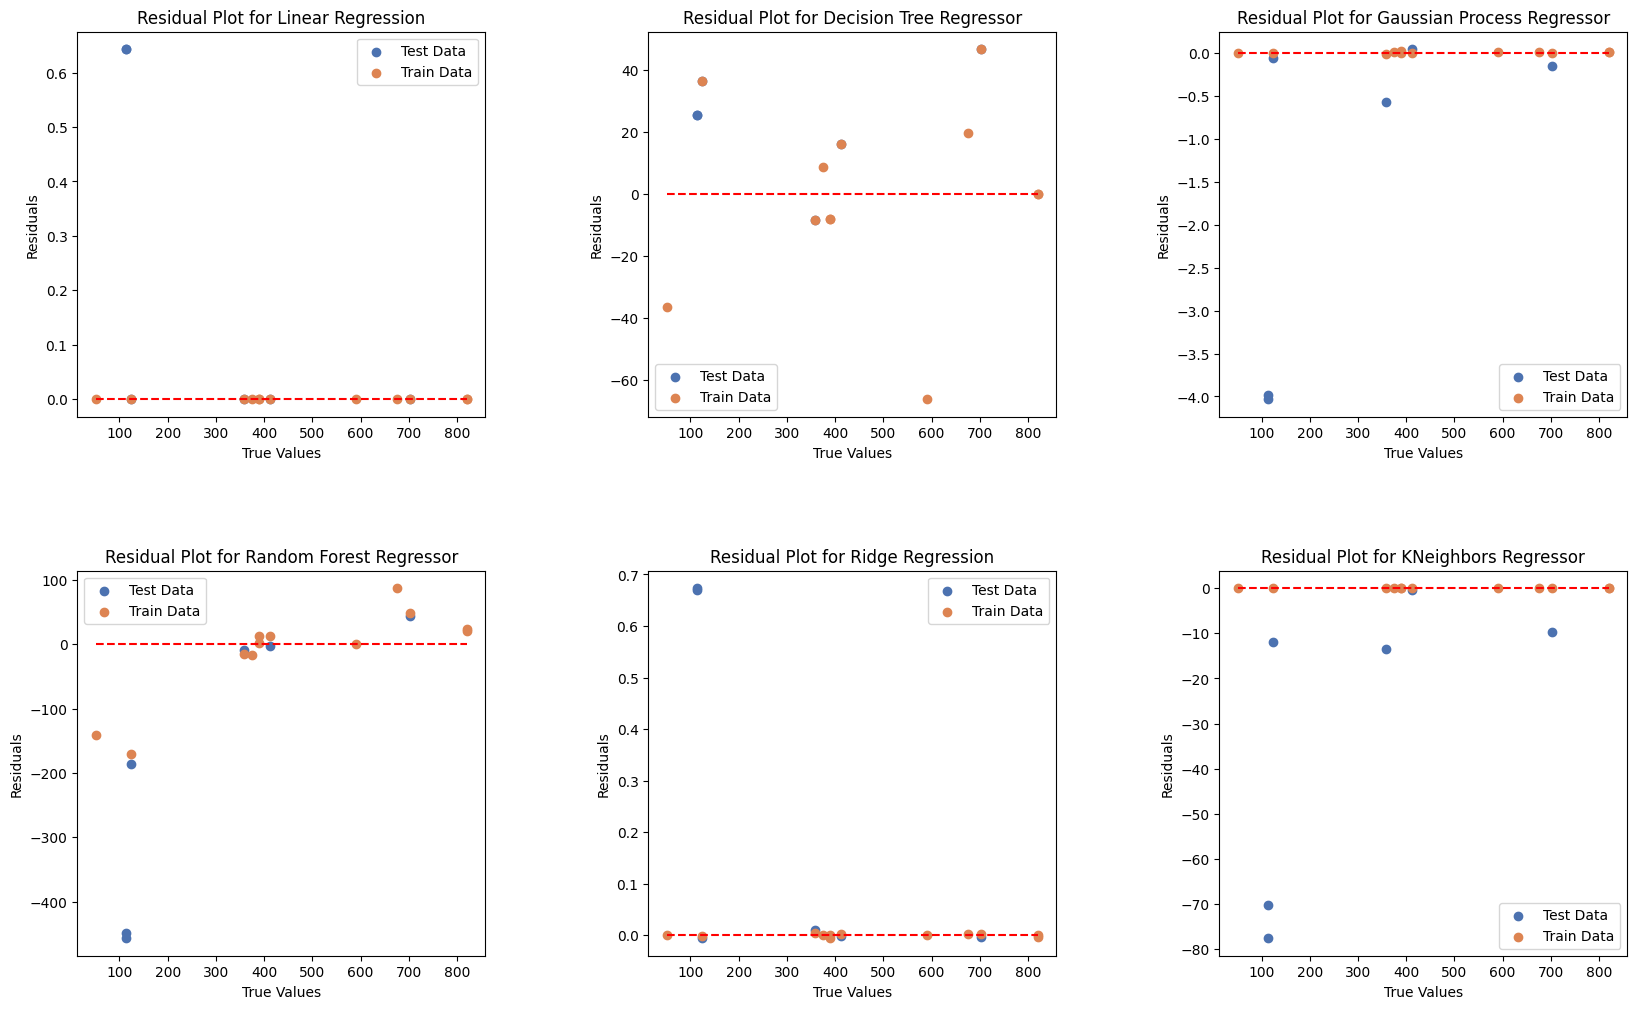

                        Model  \
0           Linear Regression   
1     Decision Tree Regressor   
2  Gaussian Process Regressor   
3     Random Forest Regressor   
4            Ridge Regression   
5        KNeighbors Regressor   

                                         Best Params     MSE Train  \
0                           {'fit_intercept': False}  5.163147e-25   
1  {'min_samples_split': 5, 'max_depth': 20, 'cri...  8.464722e+02   
2  {'alpha': 0.01, 'kernel': 1**2 * Matern(length...  5.769317e-05   
3  {'n_estimators': 100, 'min_samples_split': 2, ...  5.060764e+03   
4             {'alpha': 0.1, 'fit_intercept': False}  6.801606e-06   
5  {'weights': 'distance', 'p': 1, 'n_neighbors': 3}  0.000000e+00   

       MSE Test    RMSE Train   RMSE Test     MAE Train    MAE Test  R2 Train  \
0      0.137741  7.185504e-13    0.371135  4.879060e-13    0.214275  1.000000   
1    856.462963  2.909420e+01   29.265388  2.122222e+01   26.444444  0.985256   
2      5.407157  7.595602e-03    2

In [167]:
# Step 1: Find mutual hotels and select common columns
mutual_hotels = pd.merge(data_booking_processed, data_expedia_processed, on='hotel_name_encoded', suffixes=('_booking', '_expedia'))

# Step 2: Create the target variable 'price_difference'
mutual_hotels['price_difference'] = mutual_hotels['price_after_tax_booking'] - mutual_hotels['price_after_tax_expedia']
# data_combined = mutual_hotels[columns_to_keep]

# Step 4: Define the target column
target_column = 'price_difference'

# Step 5: Train and evaluate models
results_df = train_and_evaluate_models(mutual_hotels, target_column)
print(results_df)

## Part E - perform Reverse Engineering to the sorting algorithms of the websites 

In [168]:
# Combining and splitting the data, data preprocessed in part B
common_columns = list(set(data_booking_processed.columns) & set(data_expedia_processed.columns))
expedia_data = data_expedia_processed[common_columns]
booking_data = data_booking_processed[common_columns]

unified_data = pd.concat([expedia_data, booking_data], ignore_index=True)
unified_data.head(3)

,los,hotel_name_encoded,day_of_week,search_year,neighborhood_Chelsea,rating,quarter,neighborhood_Greenwich Village,index,start_of_month,price_after_tax,neighborhood_Upper West Side,price_before_tax,end_of_month,is_weekend,review_class,week_of_year,search_month,reviews,ttt,neighborhood_SoHo,neighborhood_New York,search_day
0,3,35,5,2024,True,7.8,3,False,68,0,310.0,False,267,4,1,1,30,7,1092,7,False,False,27
1,1,107,5,2024,False,8.2,3,False,60,0,384.0,False,329,4,1,2,30,7,1211,8,False,False,27
2,5,42,5,2024,False,8.2,3,False,68,0,265.0,False,226,4,1,2,30,7,656,3,False,True,27


Training Linear Regression...
Training Decision Tree Regressor...
Training Gaussian Process Regressor...
Training Random Forest Regressor...
Training Ridge...
Training KNeighbors Regressor...


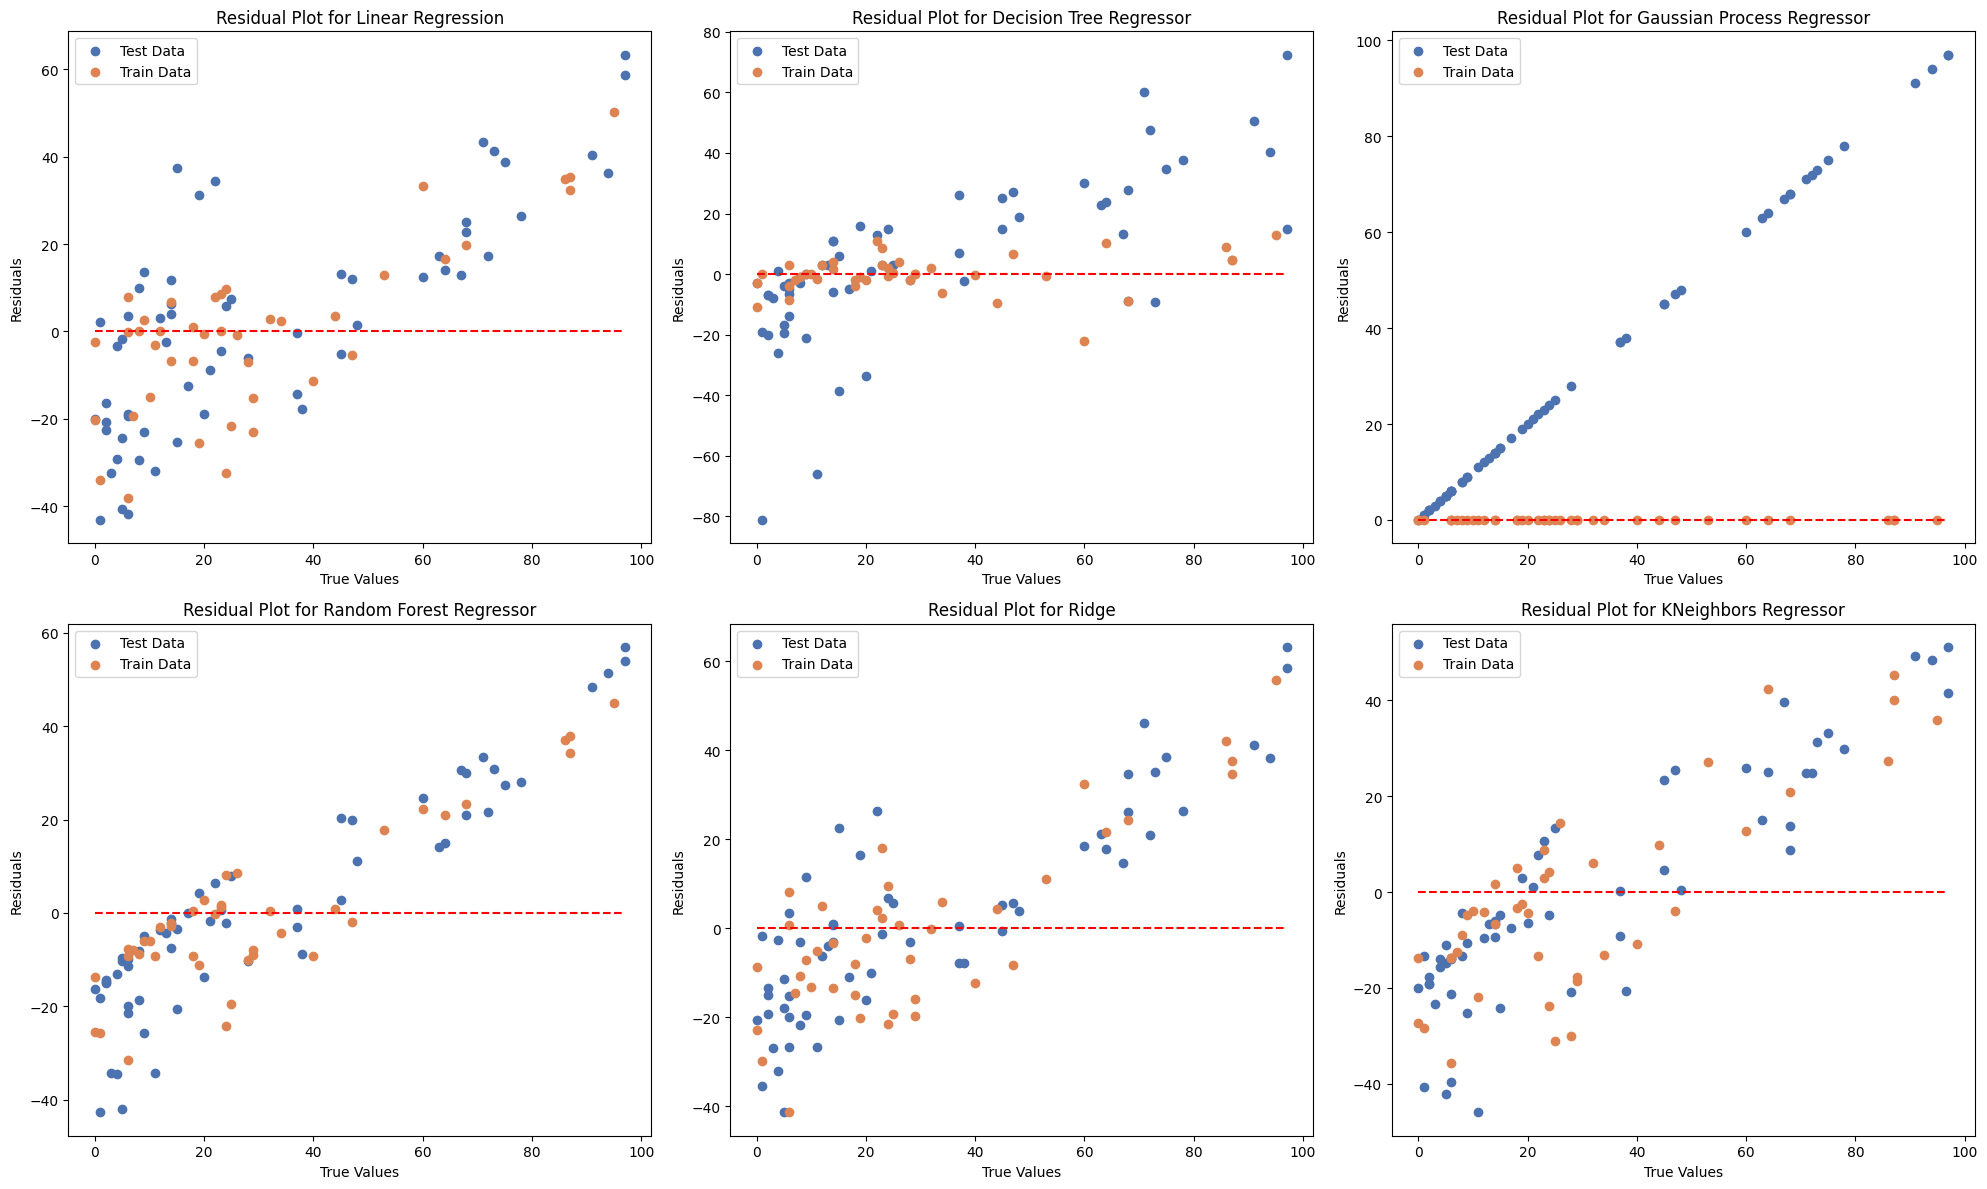

                        Model  \
0           Linear Regression   
1     Decision Tree Regressor   
2  Gaussian Process Regressor   
3     Random Forest Regressor   
4                       Ridge   
5        KNeighbors Regressor   

                                         Best Params     MSE Train  \
0                           {'fit_intercept': False}  3.716254e+02   
1  {'min_samples_split': 5, 'max_depth': 10, 'cri...  4.067276e+01   
2  {'alpha': 0.01, 'kernel': 1**2 * RBF(length_sc...  1.549798e-07   
3  {'n_estimators': 200, 'min_samples_split': 10,...  3.029109e+02   
4              {'alpha': 10, 'fit_intercept': False}  4.073933e+02   
5   {'weights': 'uniform', 'p': 1, 'n_neighbors': 7}  4.175809e+02   

      MSE Test  RMSE Train  RMSE Test  MAE Train   MAE Test  R2 Train  \
0   633.174455   19.277587  25.162958  14.101548  20.400355  0.429403   
1   703.936323    6.377520  26.531798   4.426829  18.942090  0.937551   
2  1828.305085    0.000394  42.758684   0.000300  31.08474

In [169]:
def train_and_evaluate_models_reverse_engineering(data):
    """
    Trains multiple regression models on a given dataset, evaluates their performance, and calculates error metrics.
    Also, plots residuals of each model in a grid layout.

    Parameters:
        data (pd.DataFrame): The dataset containing features and target variable.

    Returns:
        pd.DataFrame: A DataFrame containing the performance metrics of each model.
    """
    # Splitting the data into training and test sets based on ttt values
    train_data = data[data['ttt'] % 2 == 0]
    test_data = data[data['ttt'] % 2 != 0]

    # Target variable is hotel_index
    X_train = train_data.drop(columns=['index'])
    y_train = train_data['index']
    X_test = test_data.drop(columns=['index'])
    y_test = test_data['index']
    shuffled_indices = np.random.permutation(len(X_test))
    X_test_shuffled = X_test.iloc[shuffled_indices]
    y_test_shuffled = y_test.iloc[shuffled_indices]

    # Define parameter grids for hyperparameter tuning
    param_grids = {
        'Linear Regression': {
            'fit_intercept': [True, False]
        },
        'Decision Tree Regressor': {
            'max_depth': [5, 10, 20, None],
            'min_samples_split': [2, 5, 10],
            'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
        },
        'Gaussian Process Regressor': {
            'alpha': [1e-2, 1e-3, 1e-4],
            'kernel': [C(1.0, (1e-4, 1e3)) * RBF(1.0, (1e-4, 1e2)), C(1.0, (1e-4, 1e3)) * Matern(nu=1.5)]
        },
        'Random Forest Regressor': {
            'n_estimators': [50, 100, 200],
            'max_features': ['sqrt', 'log2'],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10]
        },
        'Ridge': {
            'alpha': [0.1, 1, 10],
            'fit_intercept': [True, False]
        },
        'KNeighbors Regressor': {
            'n_neighbors': [3, 5, 7, 10],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        }
    }

    # Models to be trained
    models = {
        "Linear Regression": LinearRegression(),
        "Decision Tree Regressor": DecisionTreeRegressor(),
        "Gaussian Process Regressor": GaussianProcessRegressor(),
        "Random Forest Regressor": RandomForestRegressor(),
        "Ridge": Ridge(),
        "KNeighbors Regressor": KNeighborsRegressor()
    }

    # Dictionary to store results
    results = []

    fig, axs = plt.subplots(2, 3, figsize=(20, 12))
    plot_row, plot_col = 0, 0

    # Evaluate each model
    for model_name, model in models.items():
        print(f"Training {model_name}...")
        
        # Use GridSearchCV if the number of parameter combinations is small, otherwise RandomizedSearchCV
        if model_name in param_grids:
            param_grid = param_grids[model_name]
            if len(param_grid) * len(list(param_grid.values())[0]) <= 10:
                model = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
            else:
                model = RandomizedSearchCV(model, param_grid, cv=5, n_iter=10, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
        
        model.fit(X_train, y_train)
        
        best_model = model.best_estimator_ if hasattr(model, 'best_estimator_') else model
        y_pred_train = best_model.predict(X_train)
        y_pred_test = best_model.predict(X_test_shuffled)

        # Calculate metrics
        mse_train = mean_squared_error(y_train, y_pred_train)
        mse_test = mean_squared_error(y_test_shuffled, y_pred_test)
        rmse_train = np.sqrt(mse_train)
        rmse_test = np.sqrt(mse_test)
        mae_train = mean_absolute_error(y_train, y_pred_train)
        mae_test = mean_absolute_error(y_test_shuffled, y_pred_test)
        r2_train = r2_score(y_train, y_pred_train)
        r2_test = r2_score(y_test_shuffled, y_pred_test)
        
        results.append({
            "Model": model_name,
            "Best Params": model.best_params_ if hasattr(model, 'best_params_') else None,
            "MSE Train": mse_train,
            "MSE Test": mse_test,
            "RMSE Train": rmse_train,
            "RMSE Test": rmse_test,
            "MAE Train": mae_train,
            "MAE Test": mae_test,
            "R2 Train": r2_train,
            "R2 Test": r2_test
        })
        
        # Plot residuals in the grid
        ax = axs[plot_row, plot_col]
        ax.scatter(y_test_shuffled, y_test_shuffled - y_pred_test, label="Test Data")
        ax.scatter(y_train, y_train - y_pred_train, label="Train Data")
        ax.hlines(y=0, xmin=min(y_train.min(), y_test_shuffled.min()), xmax=max(y_train.max(), y_test_shuffled.max()), colors='r', linestyles='dashed')
        ax.set_xlabel("True Values")
        ax.set_ylabel("Residuals")
        ax.set_title(f"Residual Plot for {model_name}")
        ax.legend()
        
        # Update subplot index
        plot_col += 1
        if plot_col > 2:
            plot_col = 0
            plot_row += 1
    
    plt.tight_layout()
    plt.show()
    
    # Display results
    results_df = pd.DataFrame(results)
    return results_df

results_df = train_and_evaluate_models_reverse_engineering(unified_data)
print(results_df)